In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install entmax

🚀 Enhanced Entmax mBART for Multilingual Translation

⚖️  Comparing Softmax vs Entmax Attention
Creating entmax mBART...
Loading model: facebook/mbart-large-50-many-to-many-mmt
Using device: cpu
Entmax alpha: 1.5
Replacing attention mechanisms with entmax...
Replacing attention in encoder layer 0 with entmax-1.5
Replacing attention in encoder layer 1 with entmax-1.5
Replacing attention in encoder layer 2 with entmax-1.5
Replacing attention in encoder layer 3 with entmax-1.5
Replacing attention in encoder layer 4 with entmax-1.5
Replacing attention in encoder layer 5 with entmax-1.5
Replacing attention in encoder layer 6 with entmax-1.5
Replacing attention in encoder layer 7 with entmax-1.5
Replacing attention in encoder layer 8 with entmax-1.5
Replacing attention in encoder layer 9 with entmax-1.5
Replacing attention in encoder layer 10 with entmax-1.5
Replacing attention in encoder layer 11 with entmax-1.5
Replacing attention in decoder layer 0 with entmax-1.5
Replacing attention in d

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Loading standard mBART for comparison...


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Source tokens (11): ['pl_PL', '▁Kobiet', 'a', '▁we', 'szła', '▁do', '▁ka', 'wia', 'rni', '.', '</s>']
Target tokens (11): ['</s>', 'en_XX', '▁The', '▁woman', '▁went', '▁to', '▁the', '▁cafe', 'teria', '.', '</s>']
Entmax translation: The woman went to the cafeteria.
Standard translation: The woman entered the cafe.

--- Encoder Self-Attention ---
Analyzing attention over 11 tokens: ['pl_PL', '▁Kobiet', 'a', '▁we', 'szła', '▁do', '▁ka', 'wia', 'rni', '.']...
Entmax layers: 12, Standard layers: 12


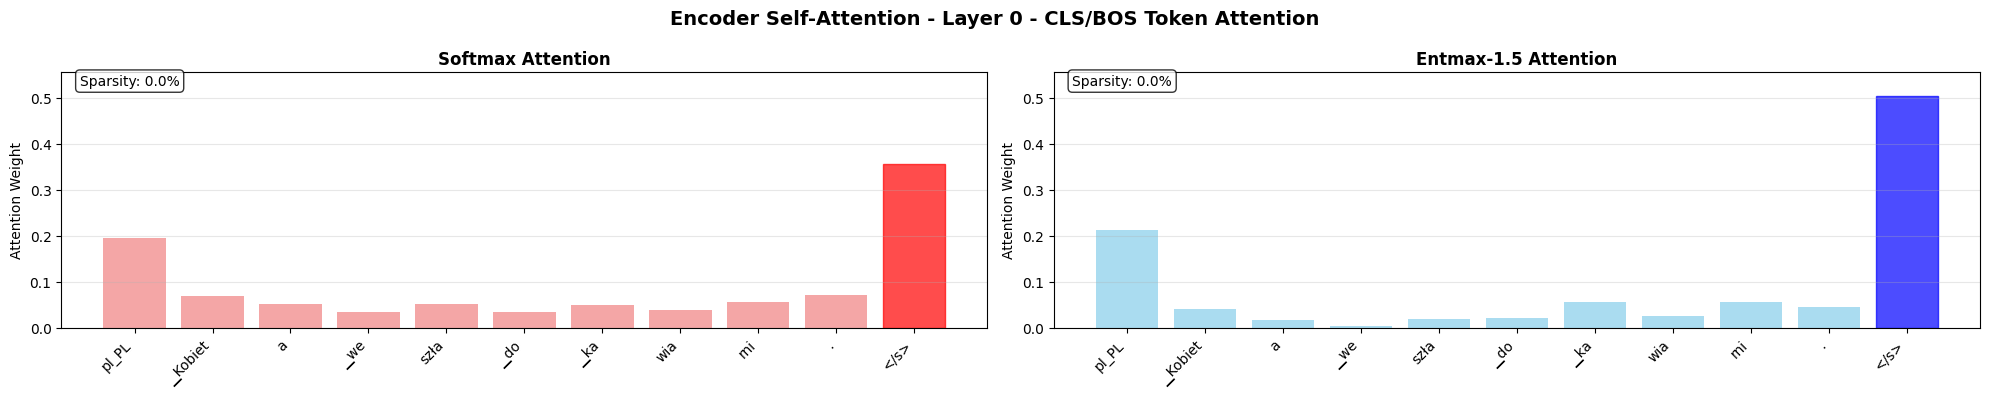

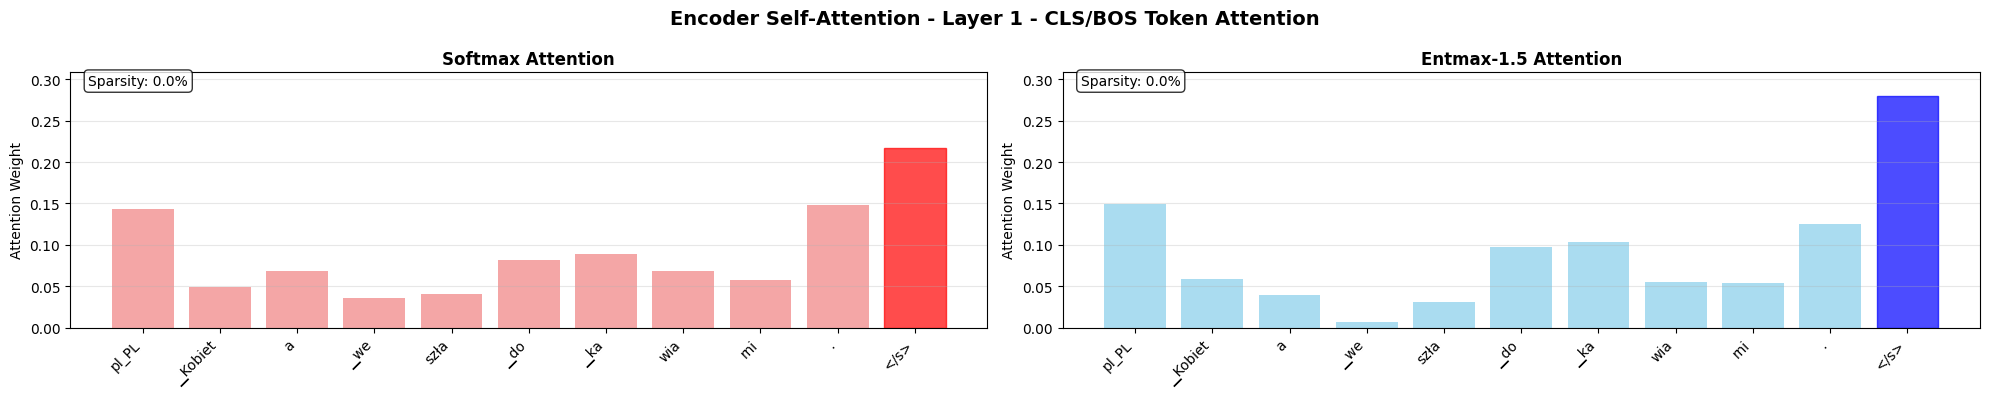

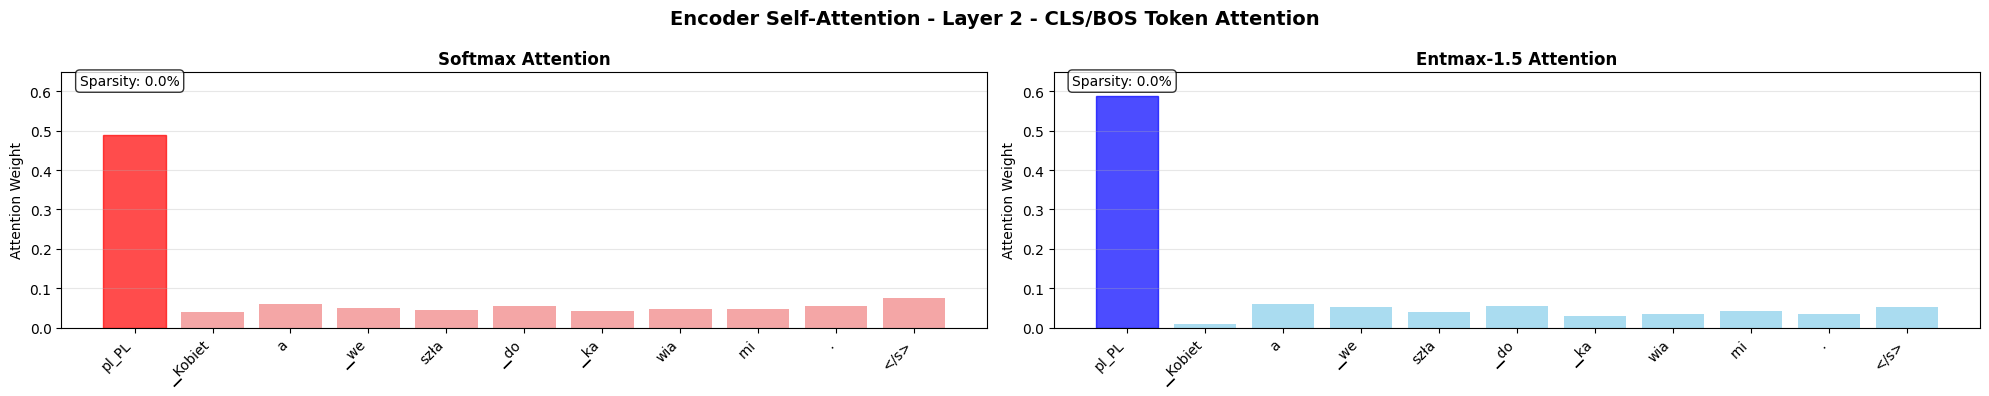

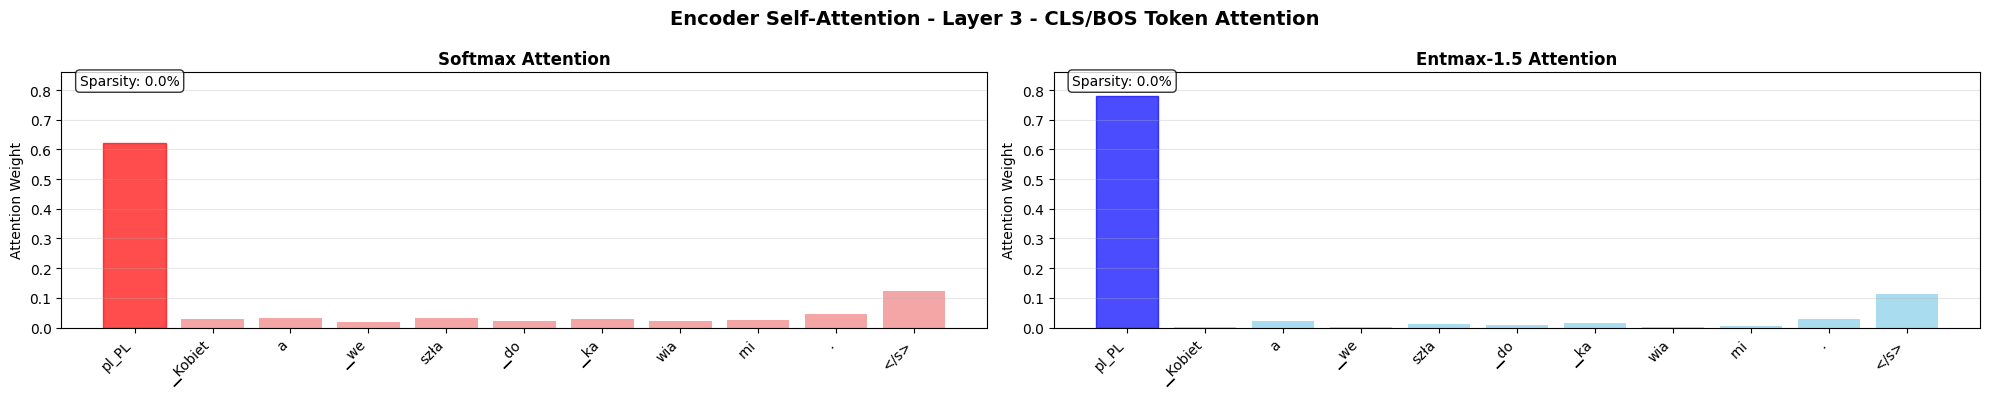

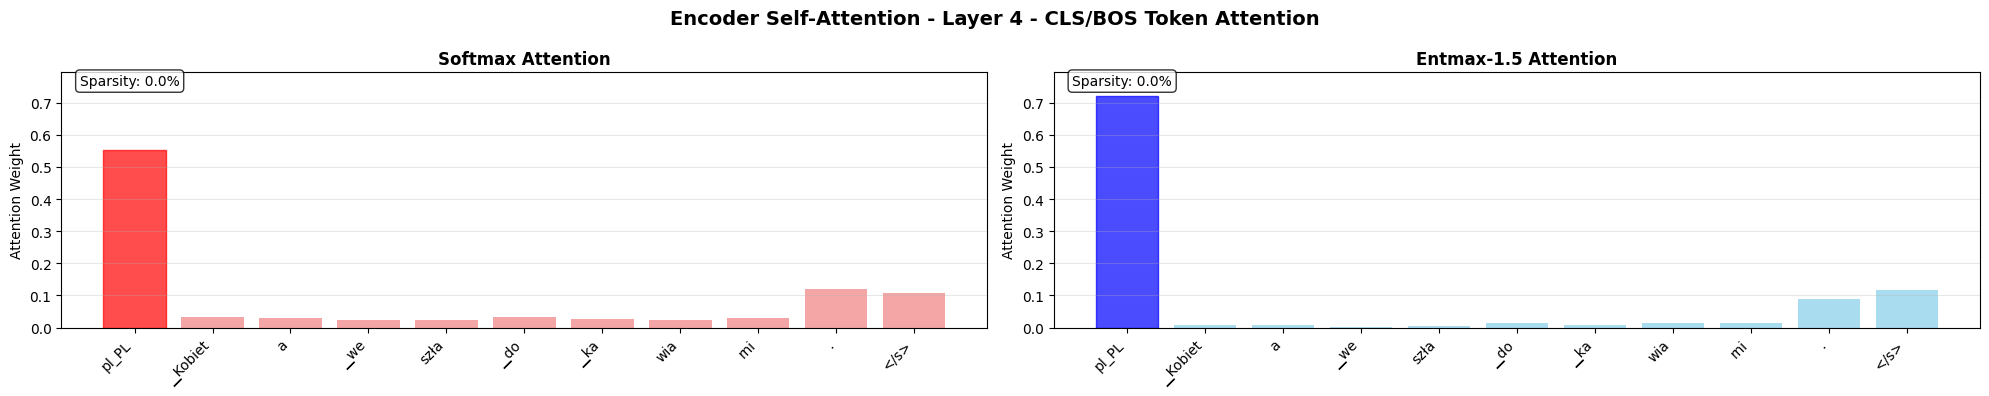

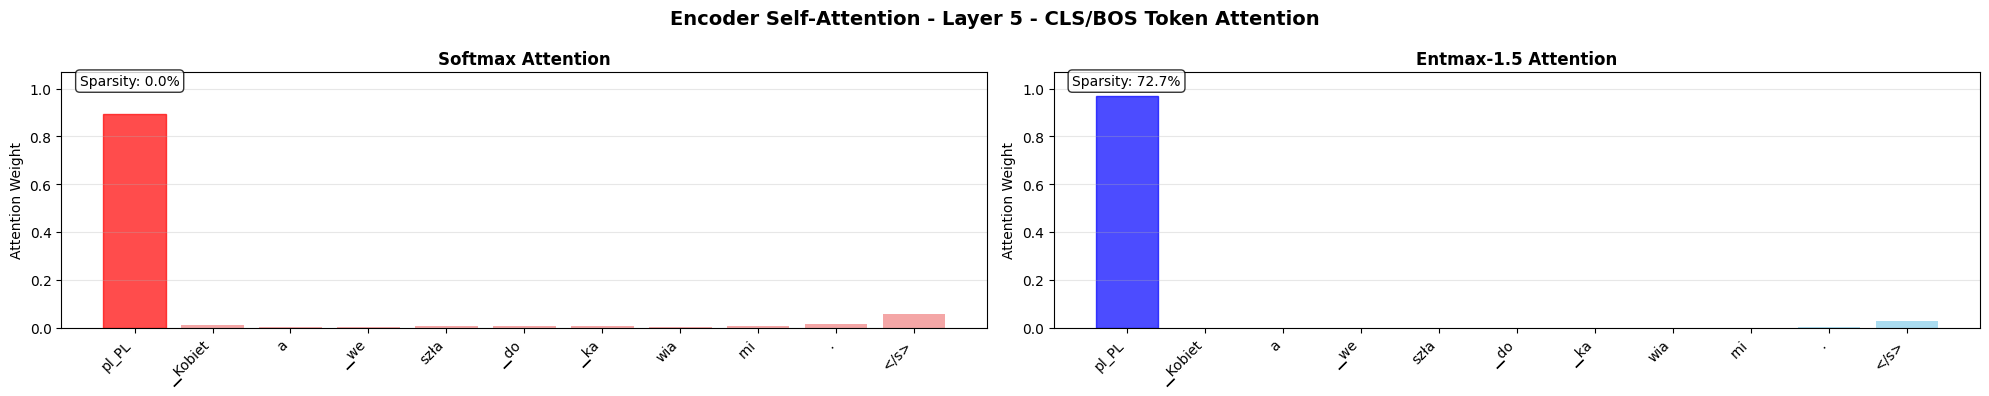

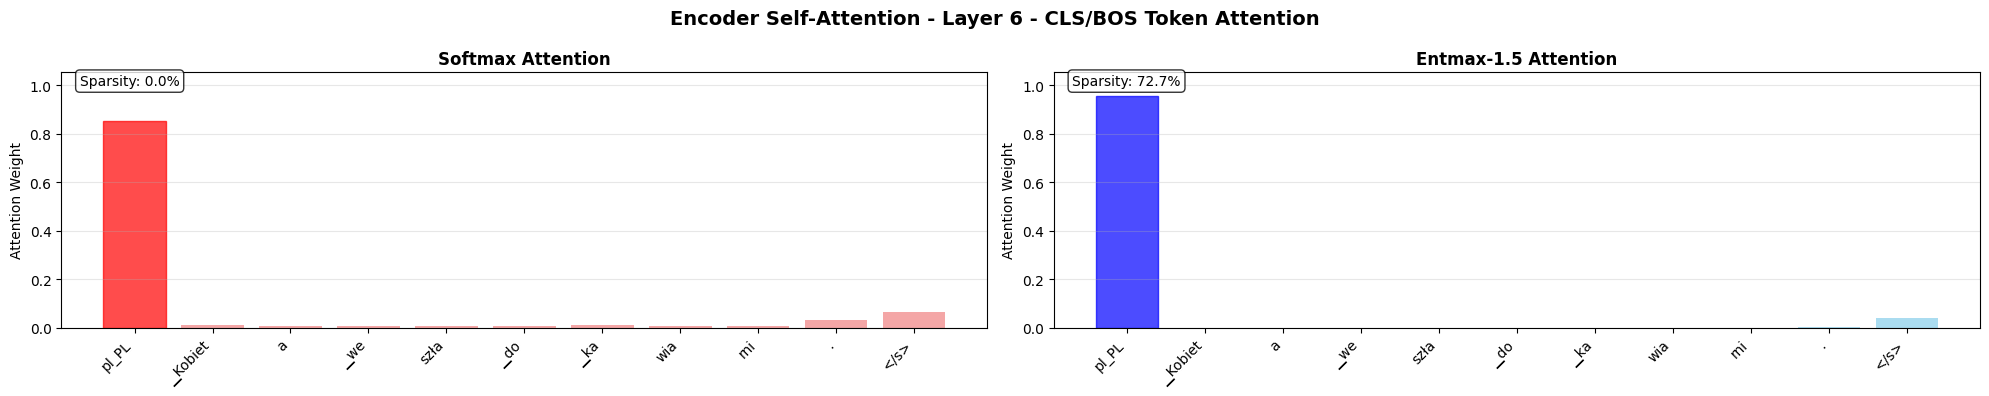

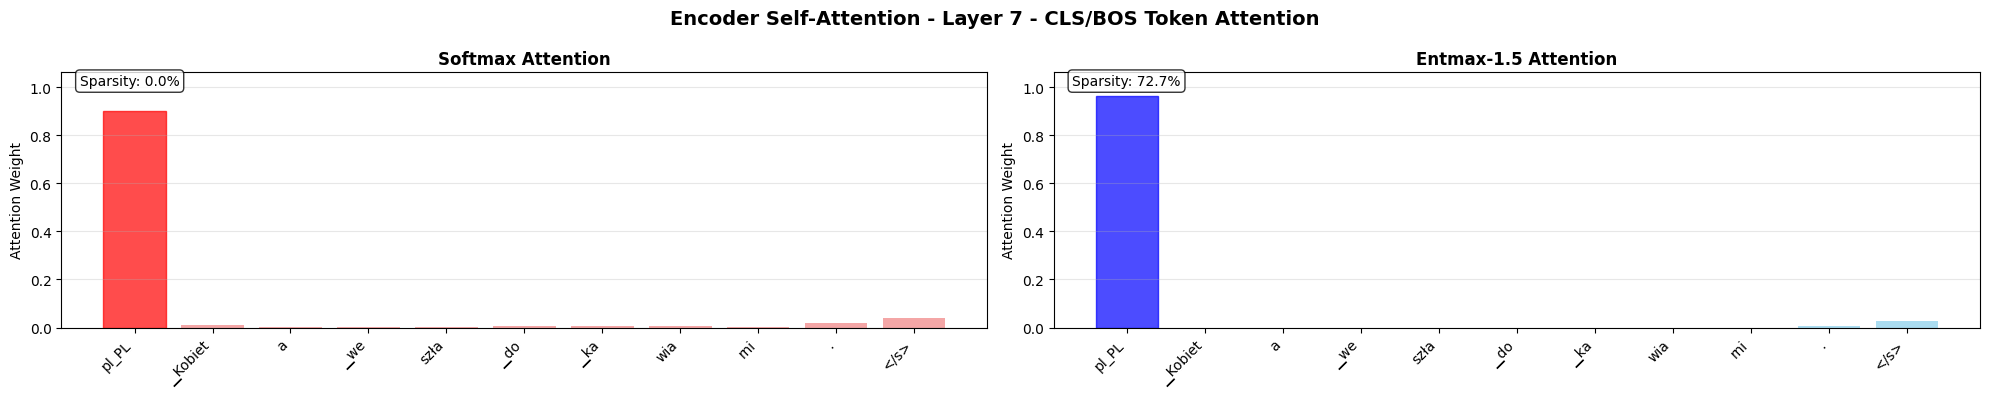

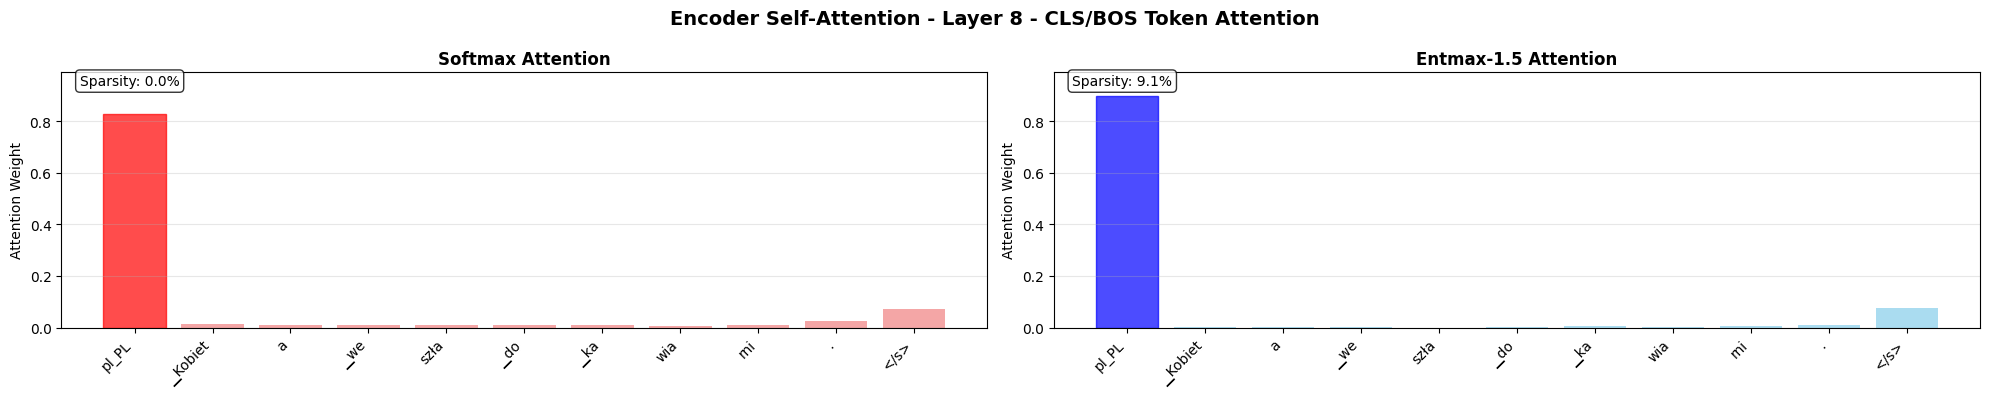

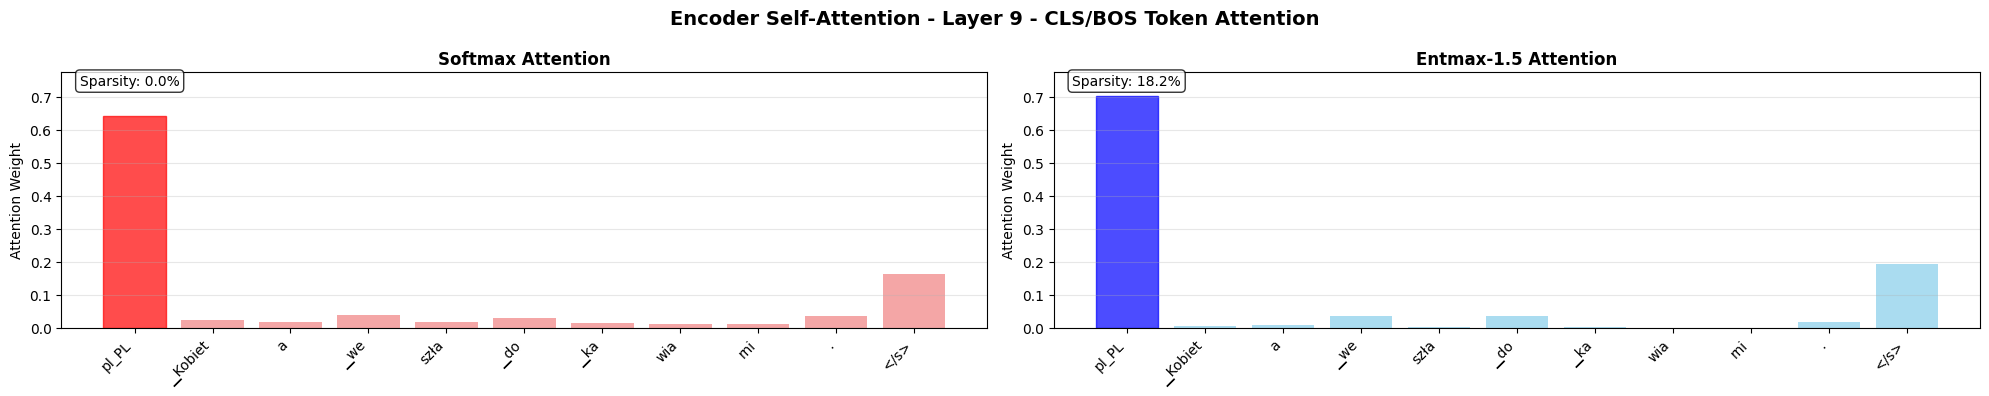

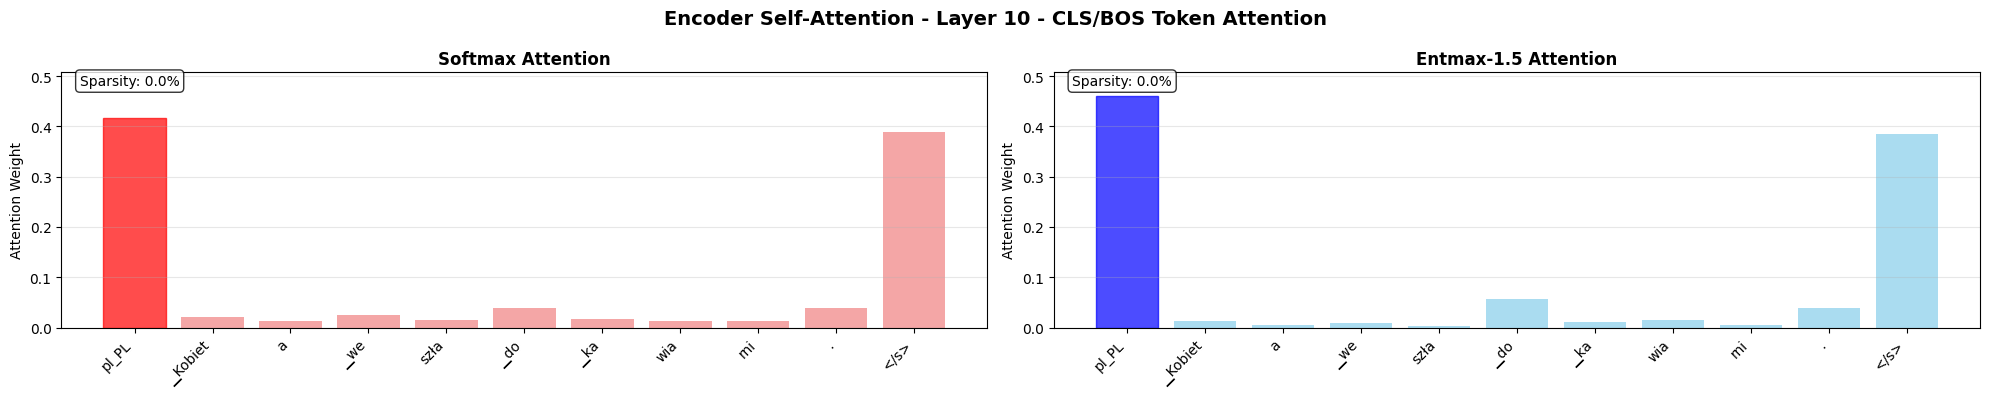

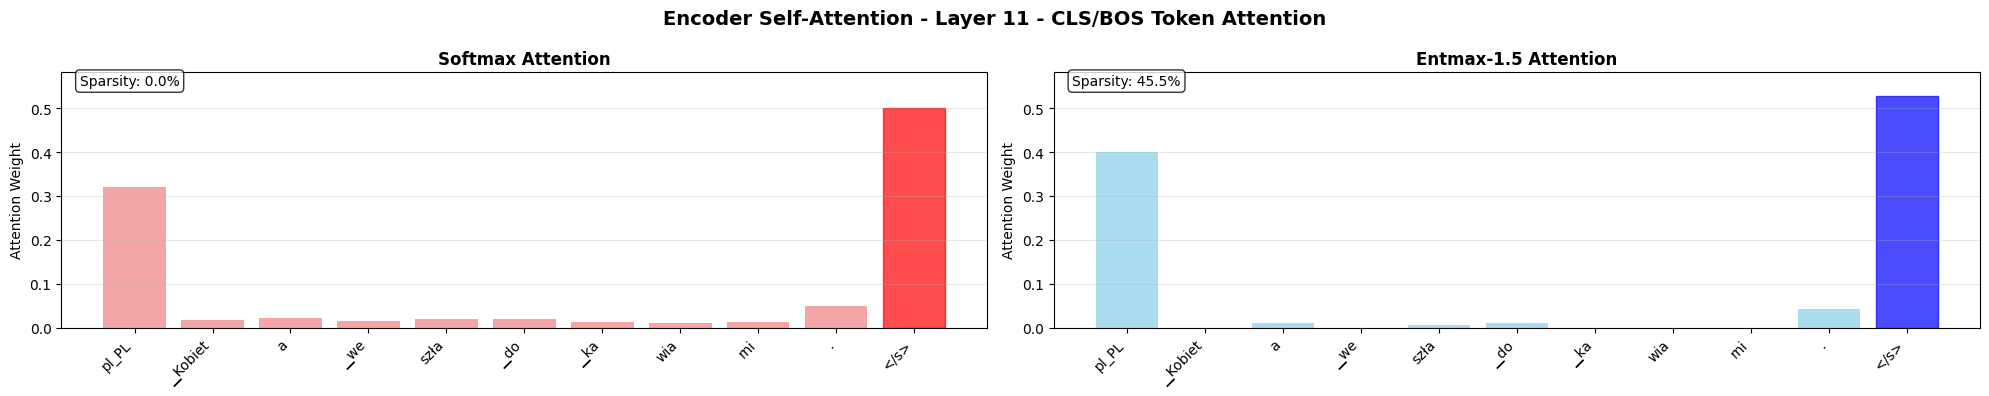


📊 Encoder Self-Attention Statistics:
--------------------------------------------------
Layer    Softmax Sparsity   Entmax Sparsity    Difference  
------------------------------------------------------------
0        0.0                0.0                0.0         
1        0.0                0.0                0.0         
2        0.0                0.0                0.0         
3        0.0                0.0                0.0         
4        0.0                0.0                0.0         
5        0.0                72.7               72.7        
6        0.0                72.7               72.7        
7        0.0                72.7               72.7        
8        0.0                9.1                9.1         
9        0.0                18.2               18.2        
10       0.0                0.0                0.0         
11       0.0                45.5               45.5        

--- Cross-Attention ---
Analyzing attention over 11 tokens: ['pl_PL',

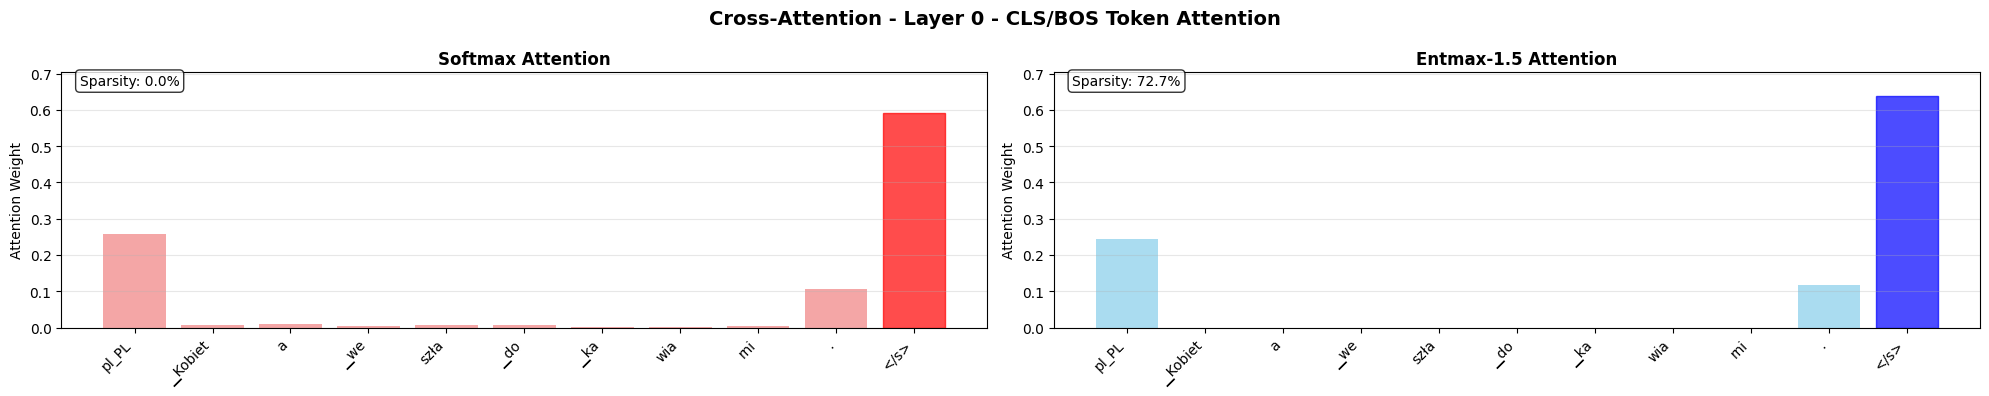

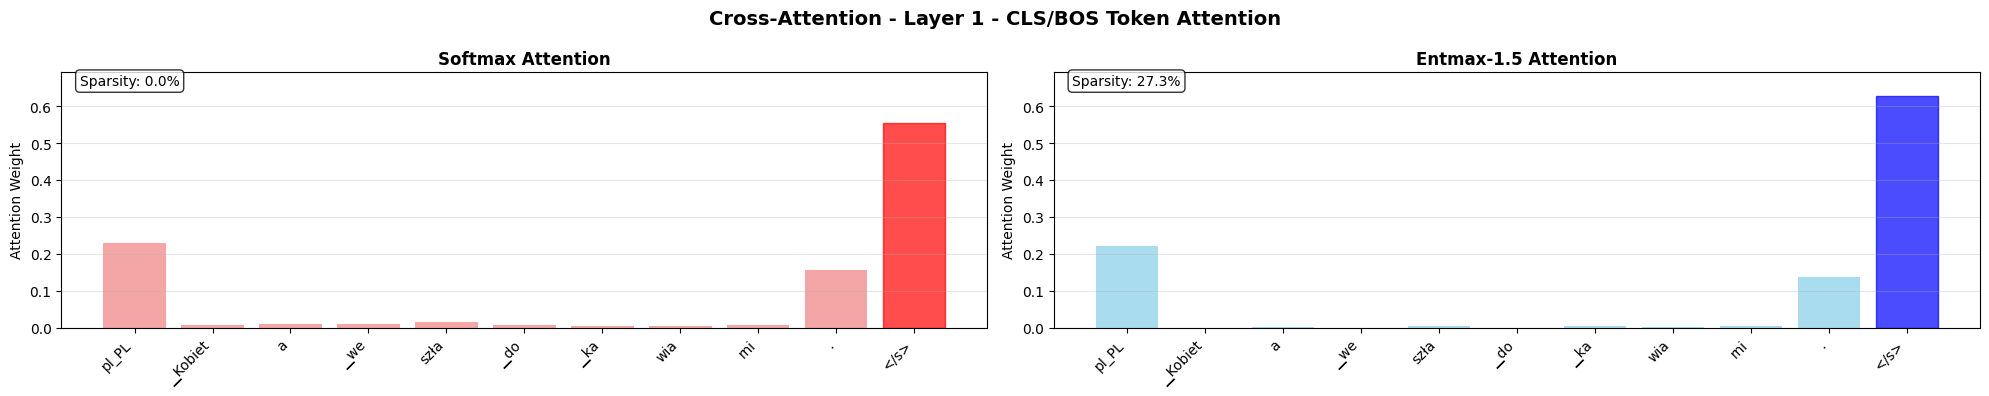

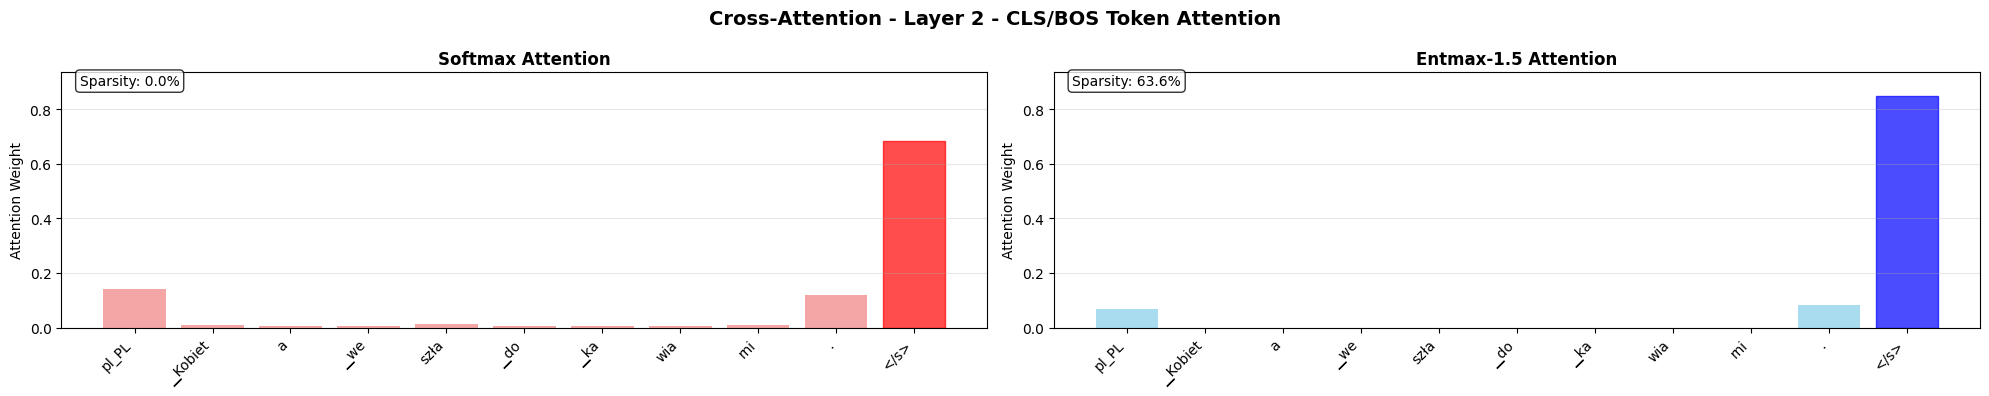

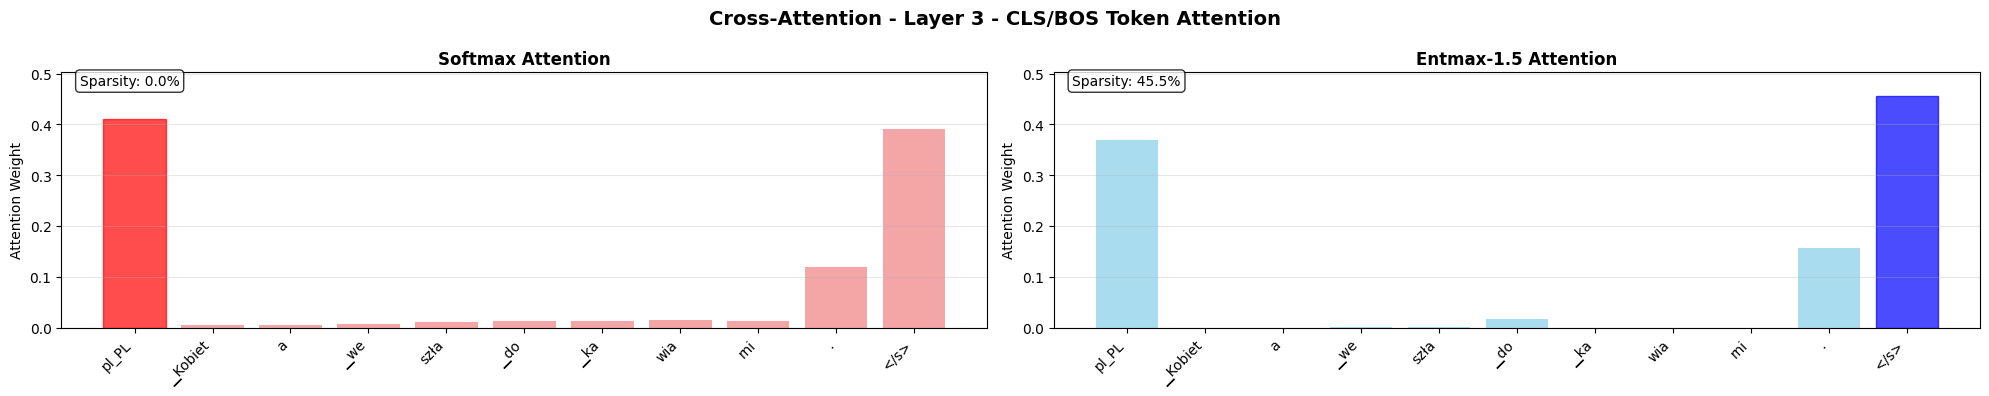

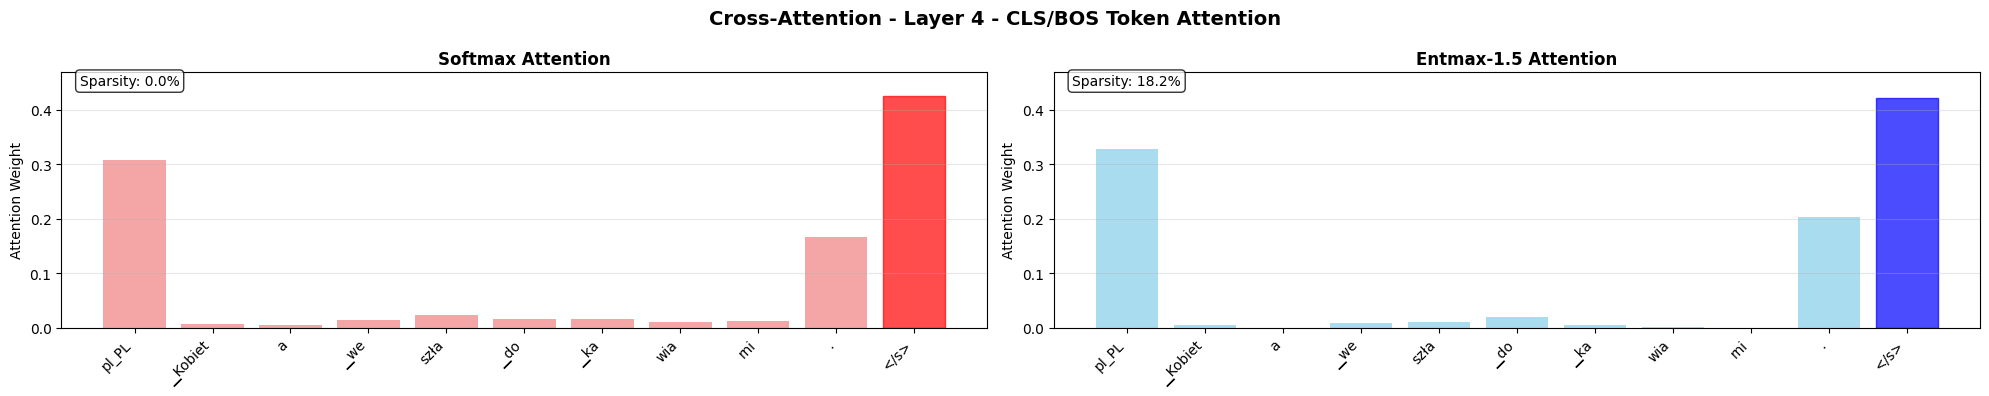

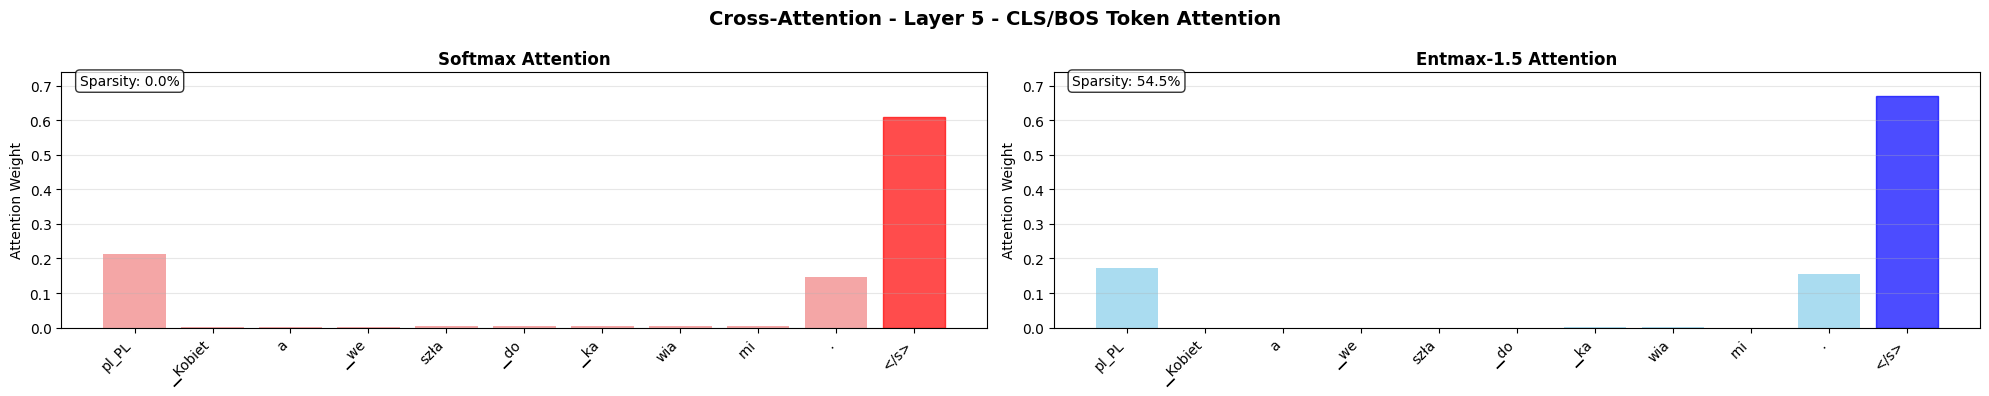

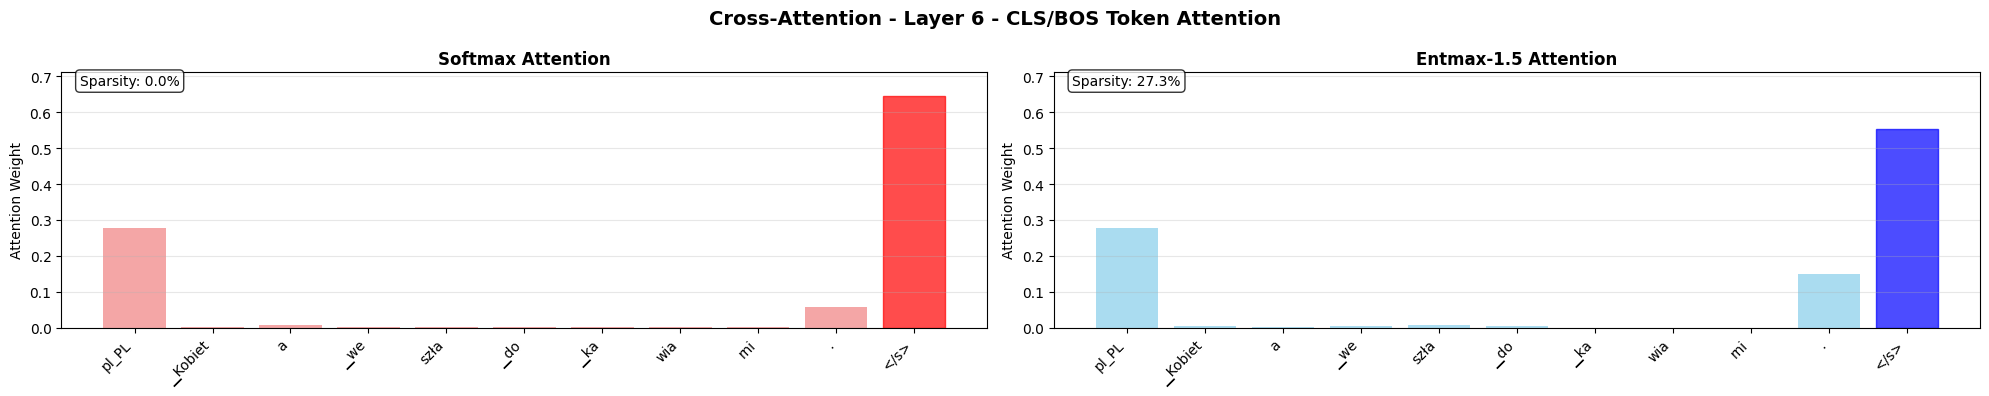

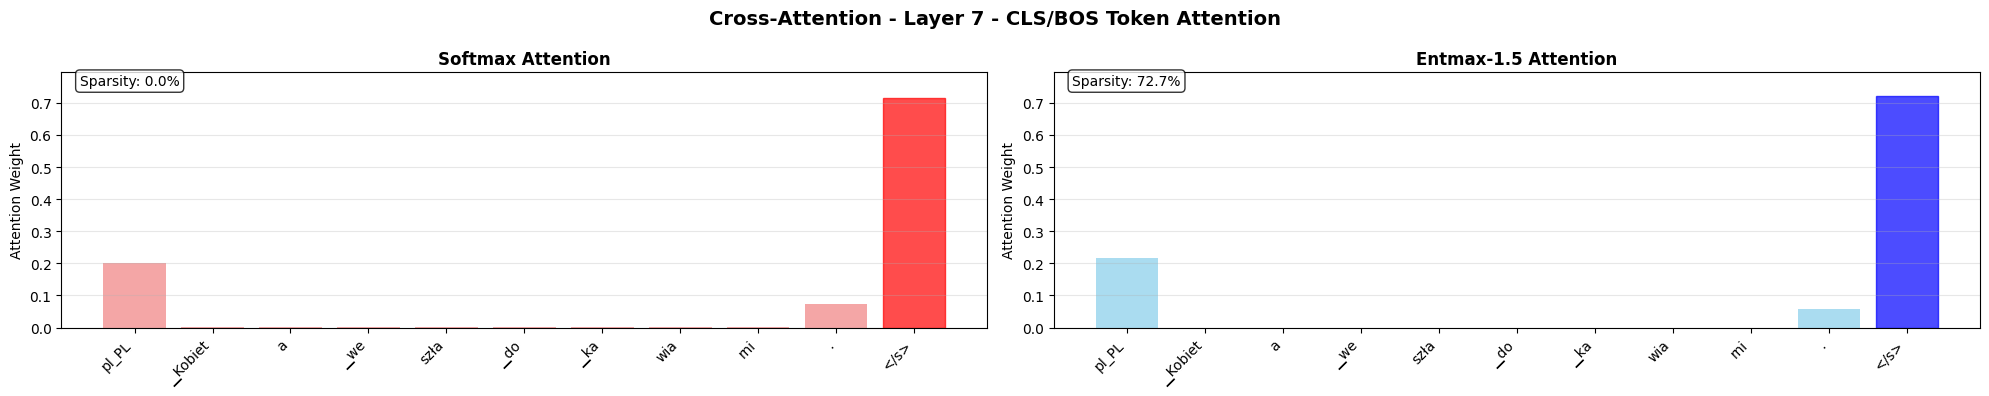

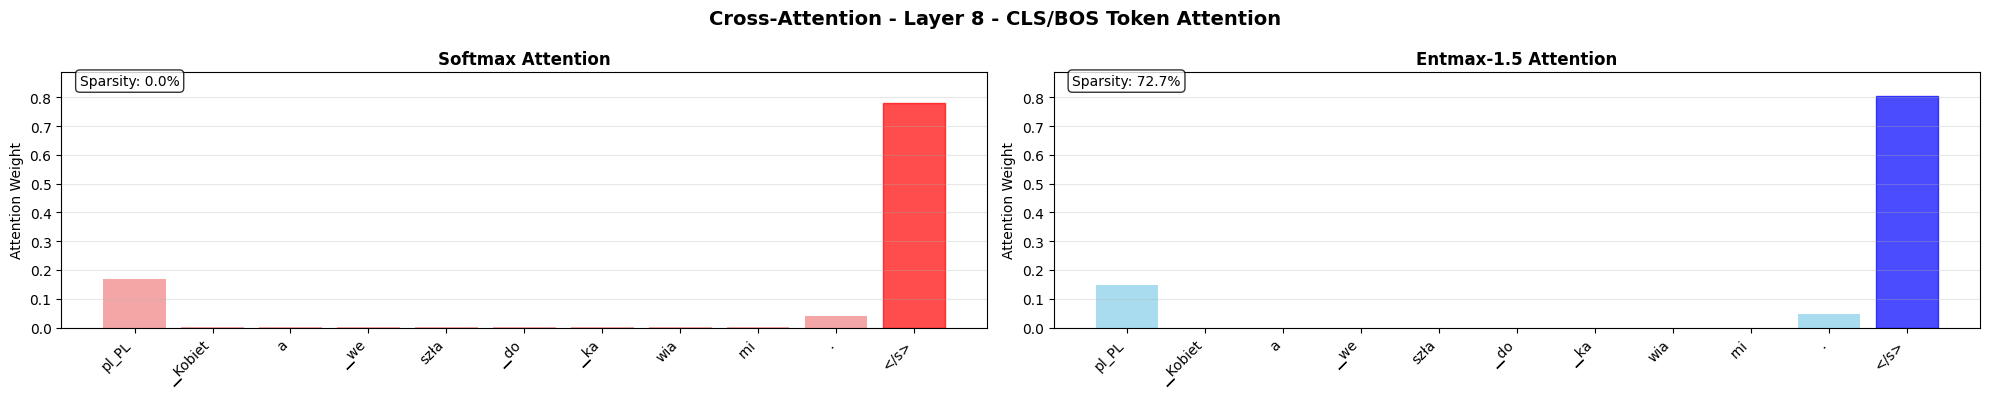

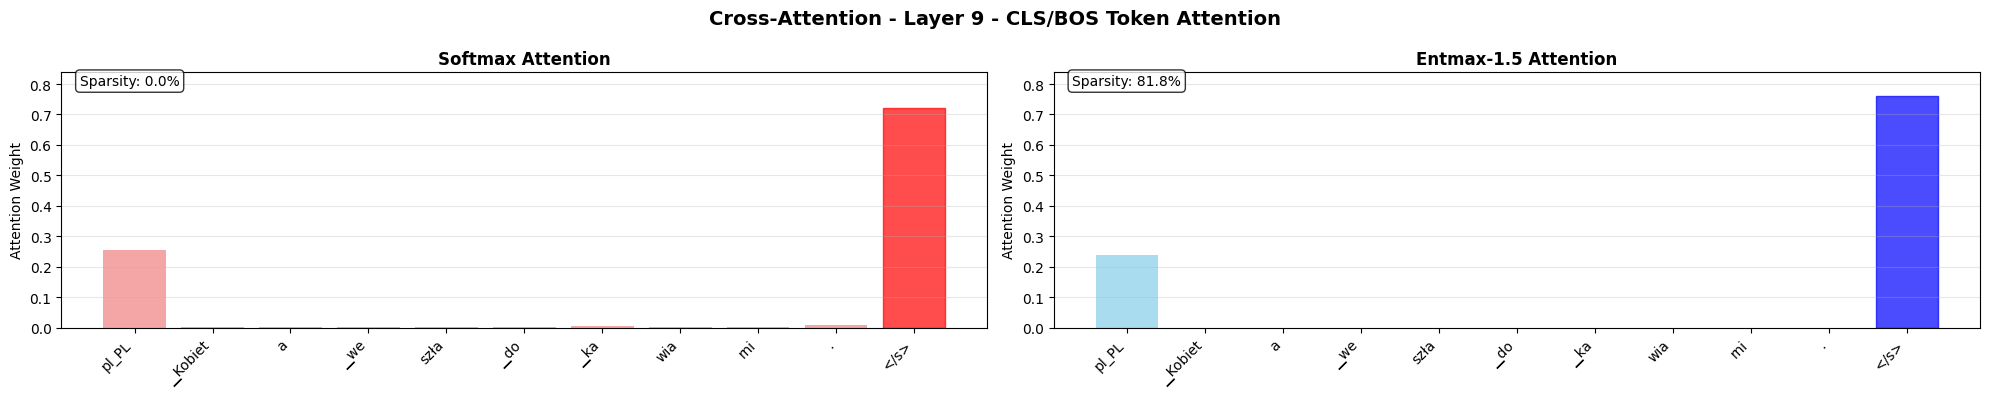

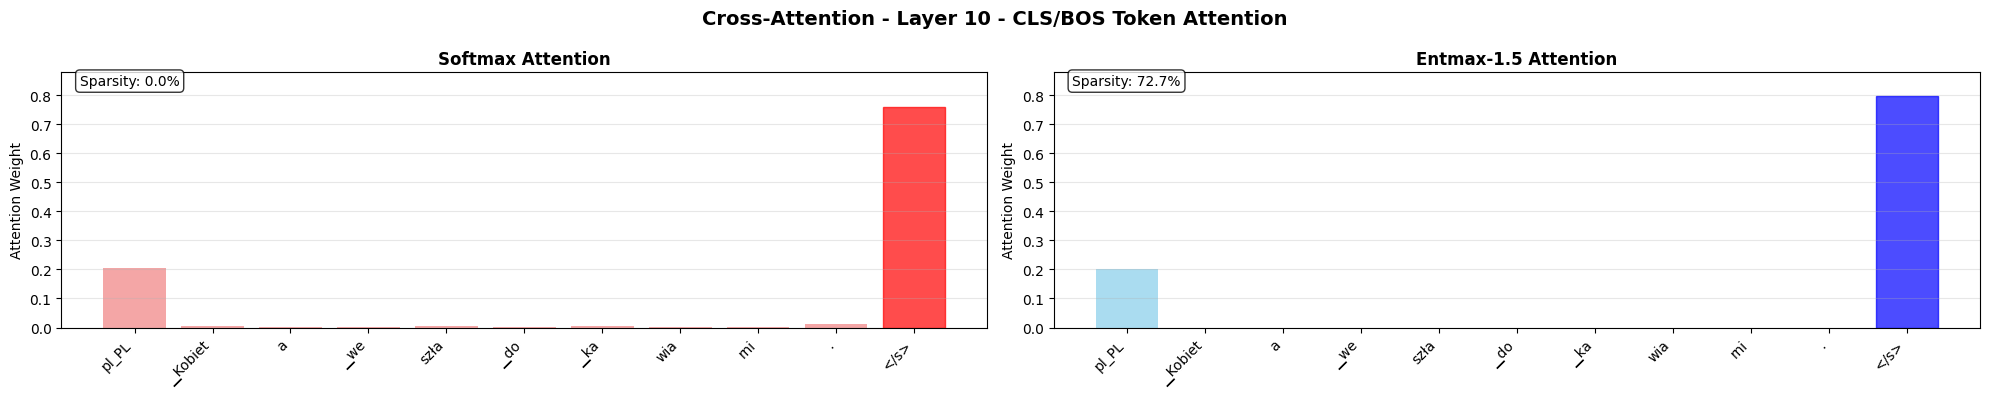

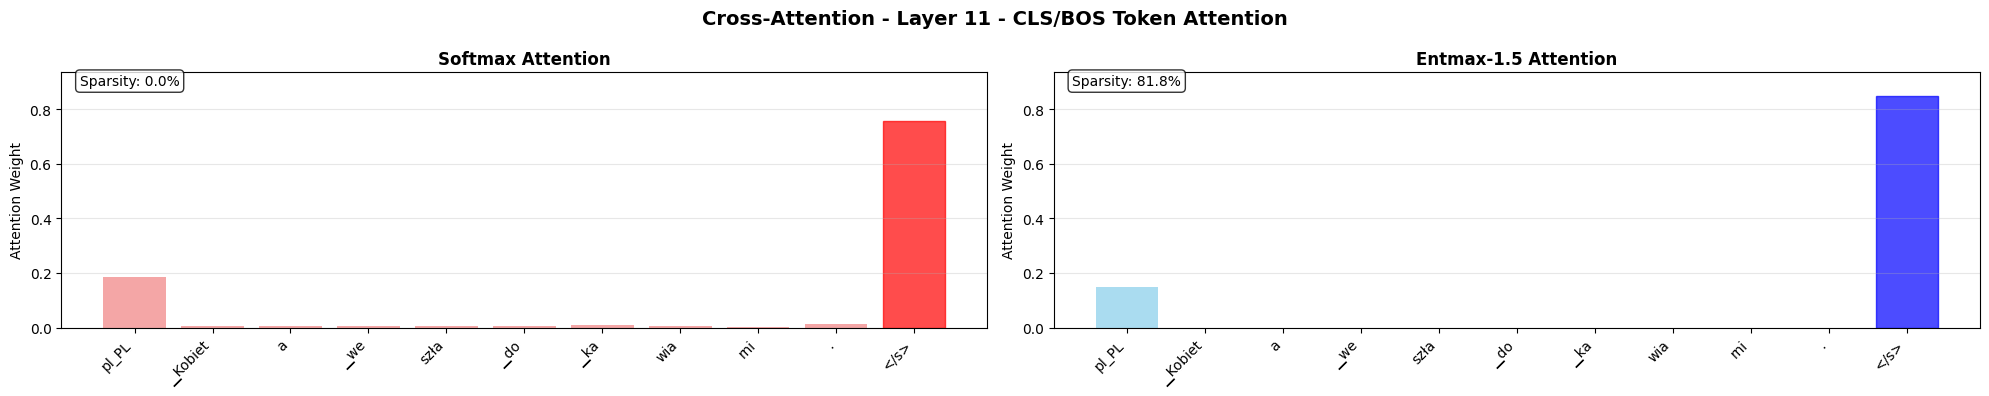


📊 Cross-Attention Statistics:
--------------------------------------------------
Layer    Softmax Sparsity   Entmax Sparsity    Difference  
------------------------------------------------------------
0        0.0                72.7               72.7        
1        0.0                27.3               27.3        
2        0.0                63.6               63.6        
3        0.0                45.5               45.5        
4        0.0                18.2               18.2        
5        0.0                54.5               54.5        
6        0.0                27.3               27.3        
7        0.0                72.7               72.7        
8        0.0                72.7               72.7        
9        0.0                81.8               81.8        
10       0.0                72.7               72.7        
11       0.0                81.8               81.8        

--- Decoder Self-Attention ---
Analyzing attention over 11 tokens: ['</s>', 

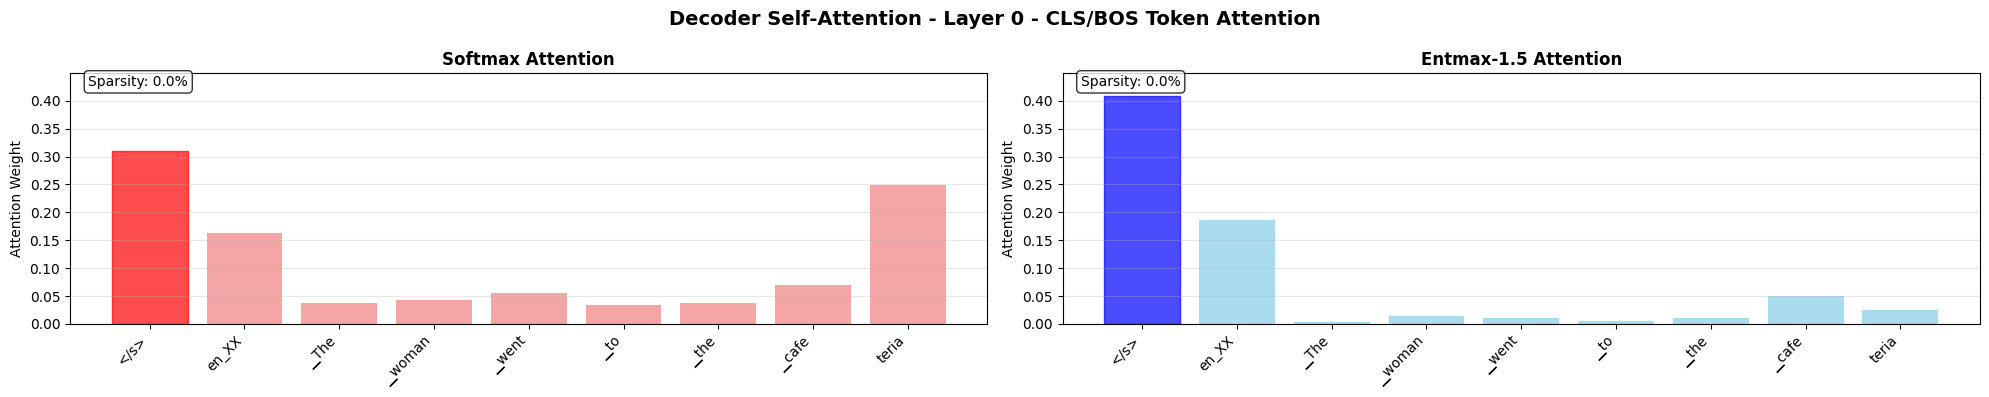

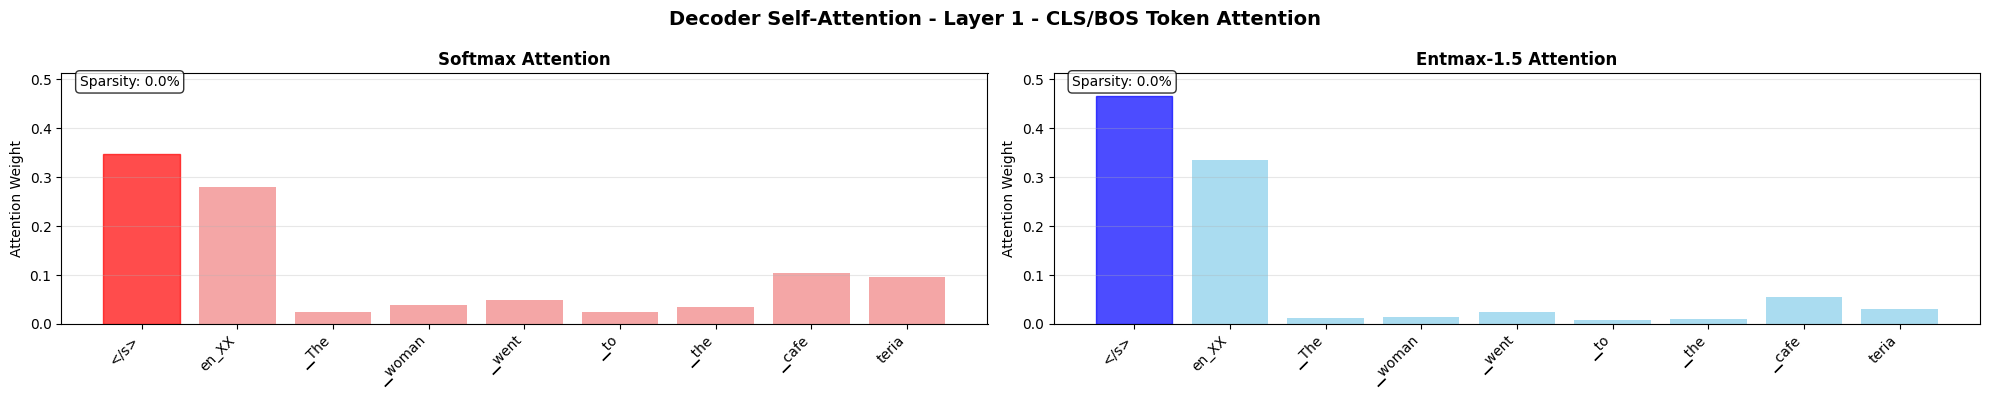

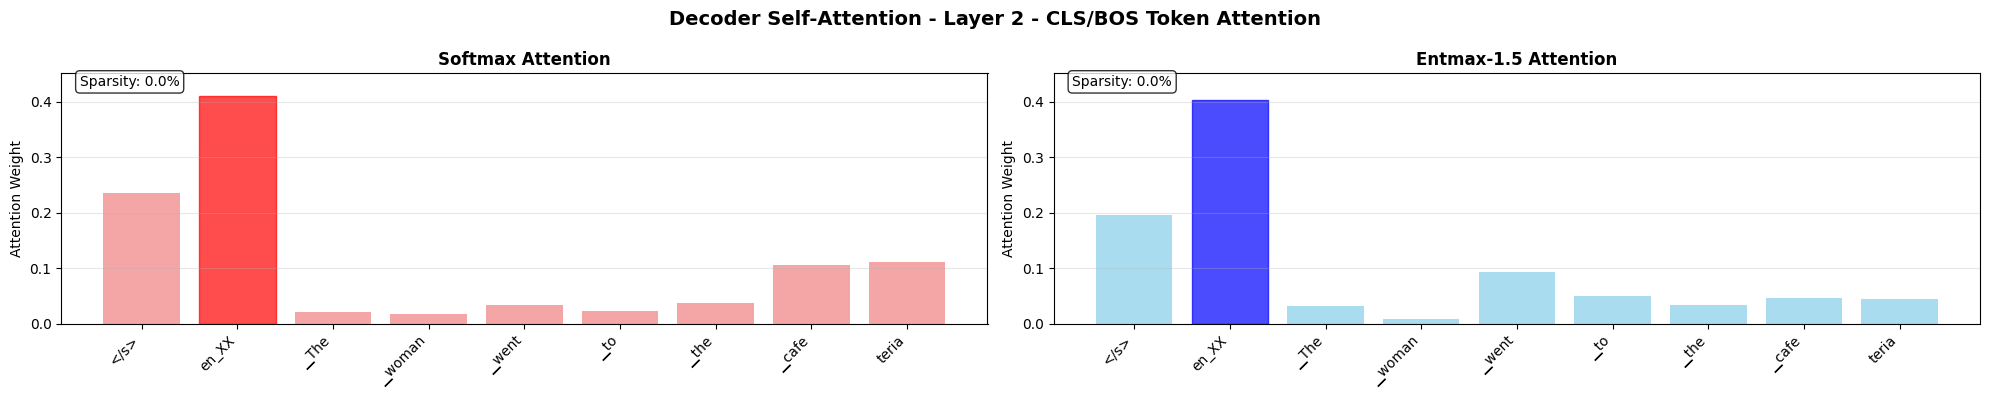

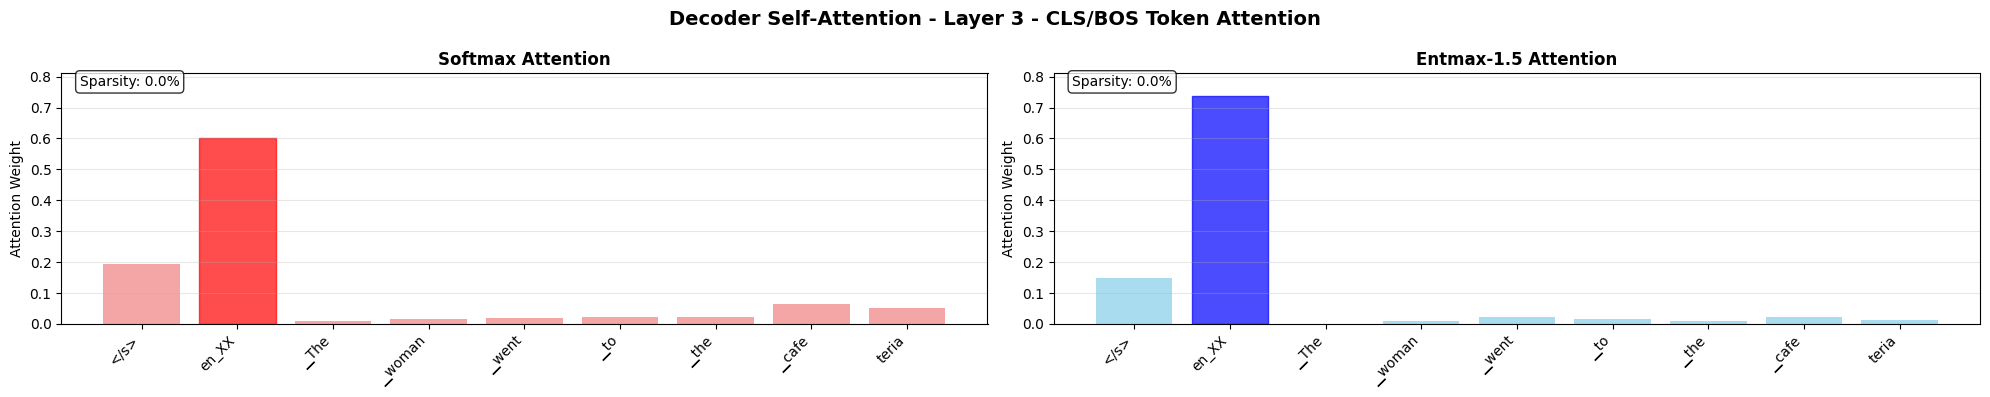

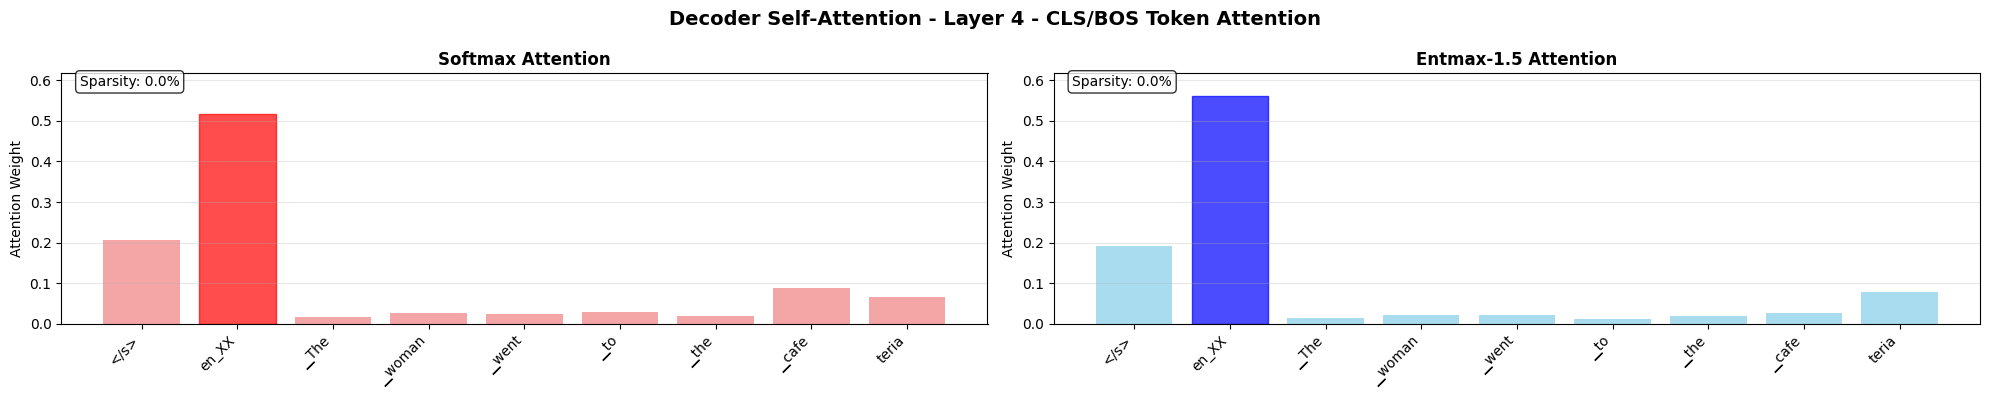

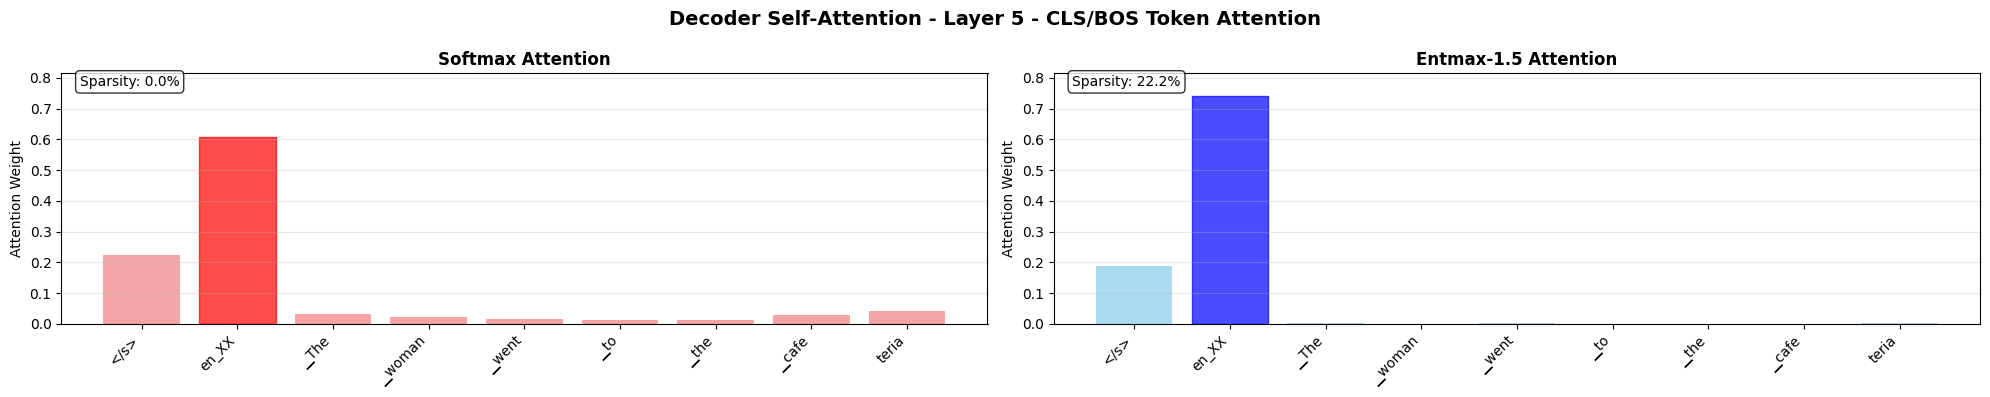

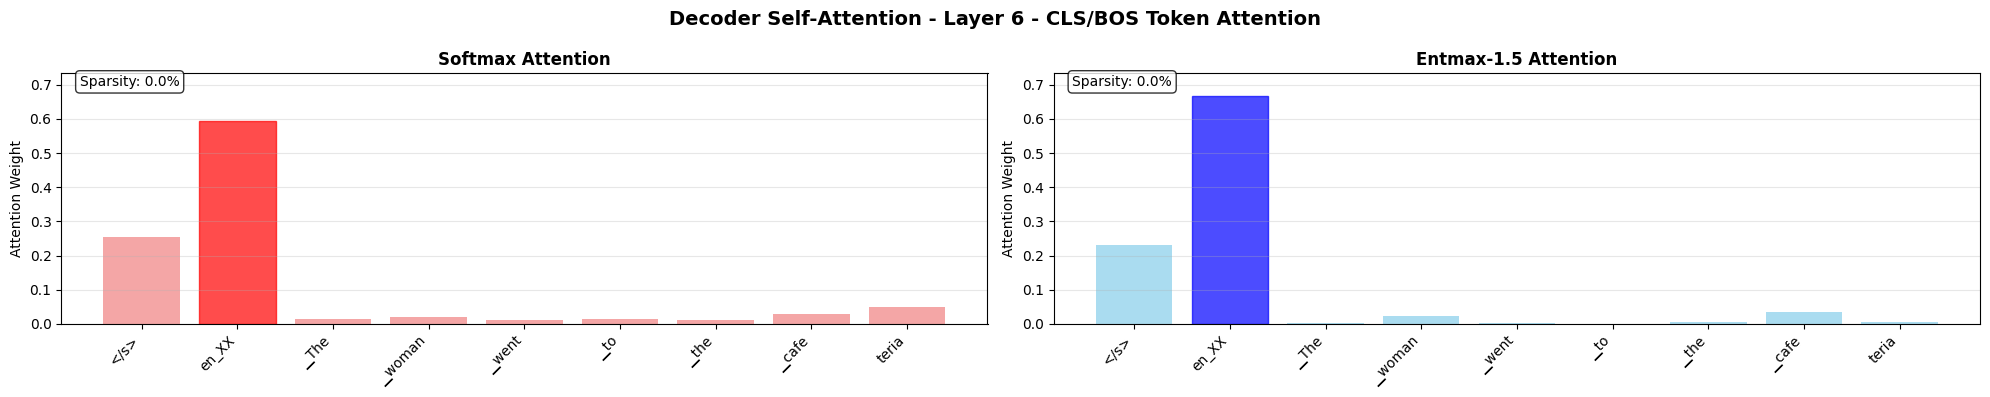

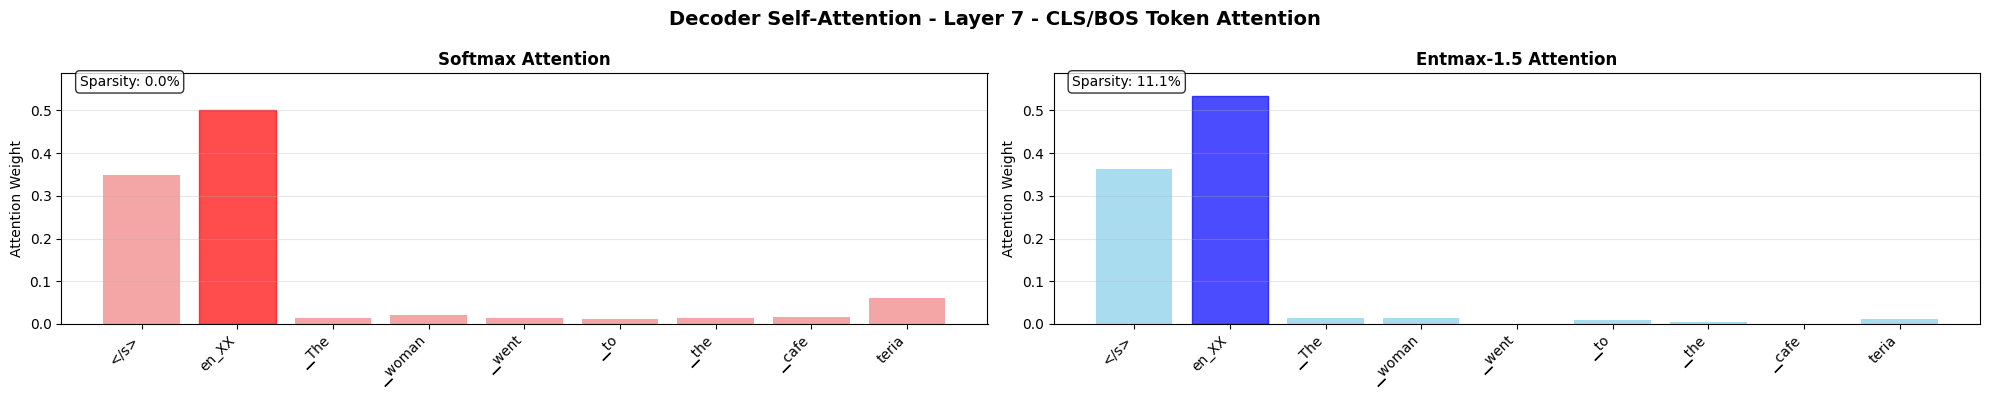

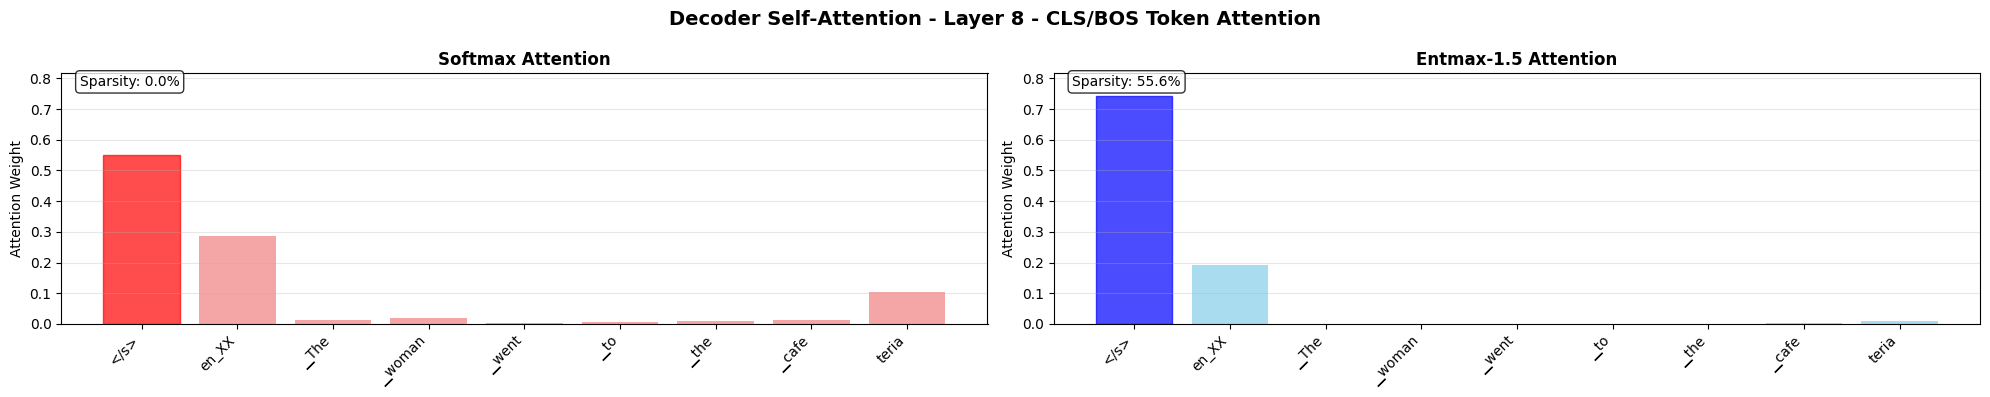

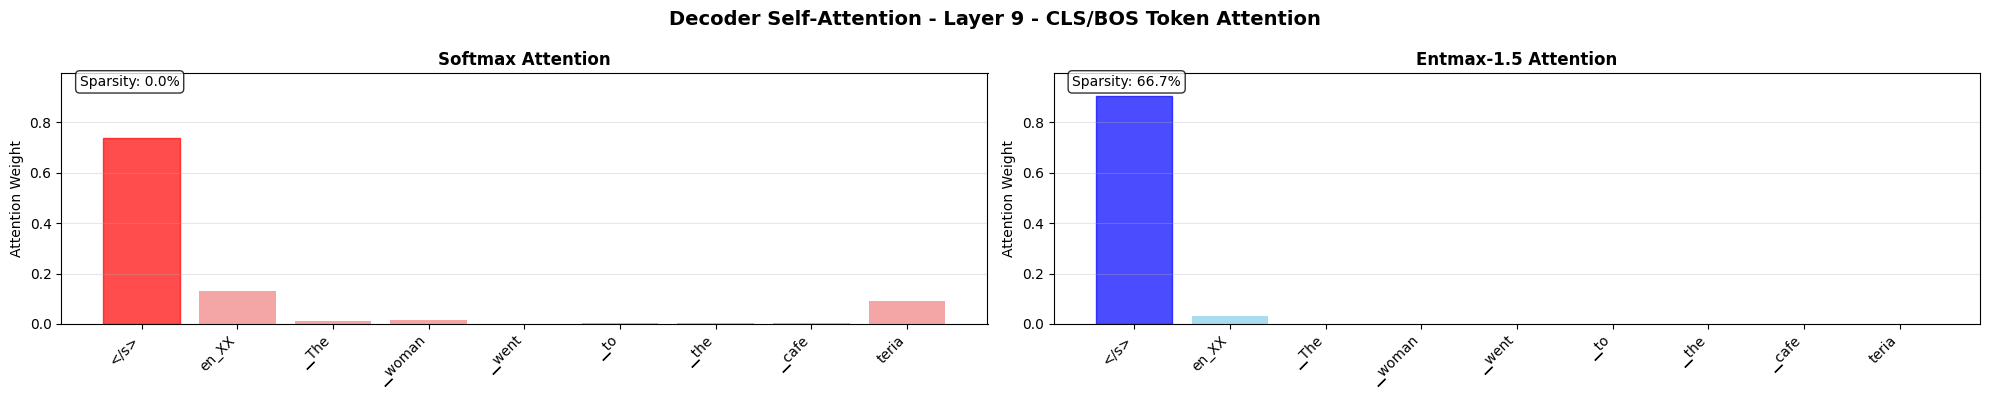

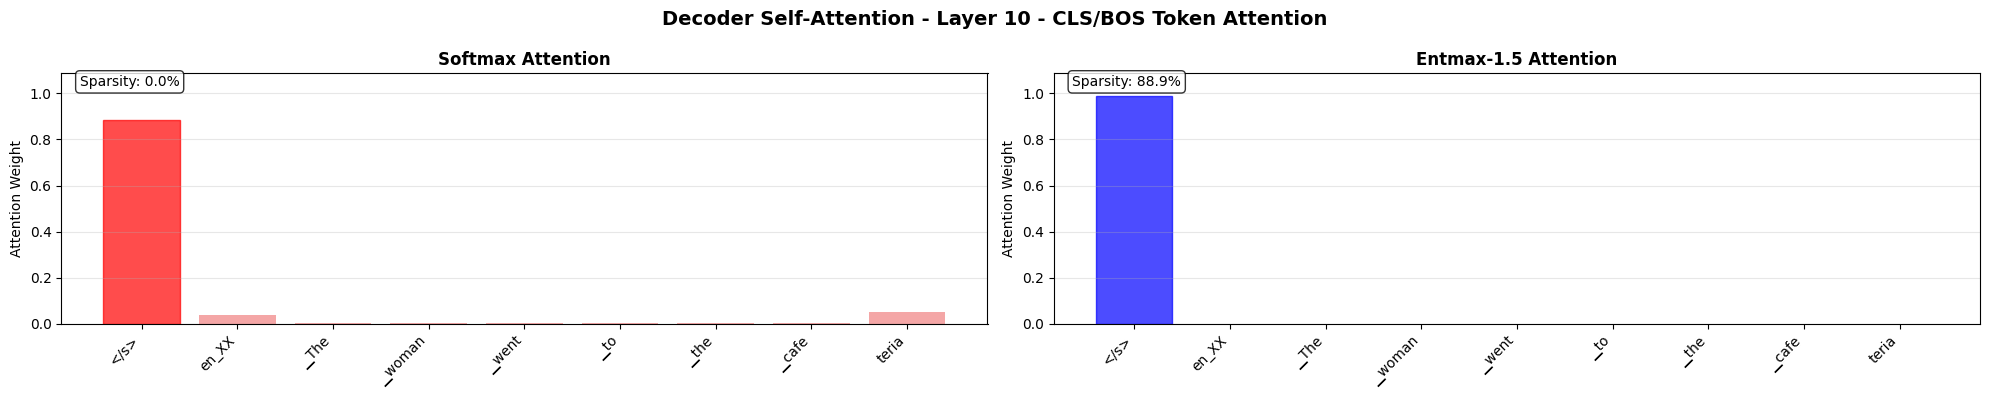

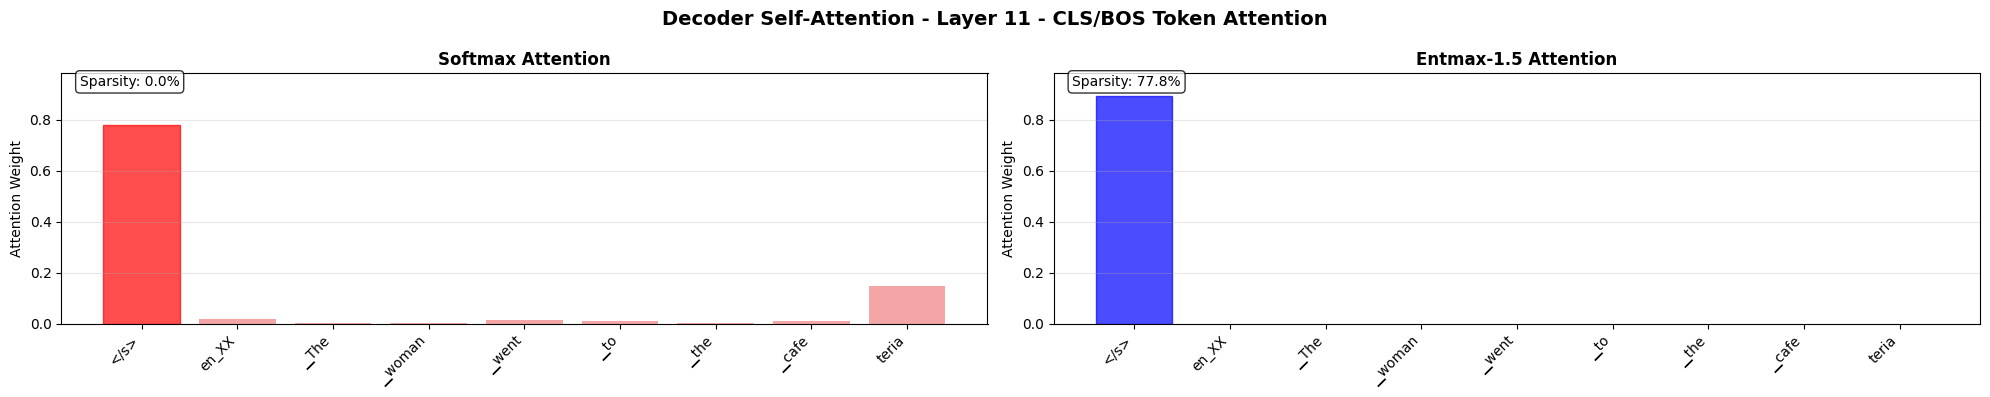


📊 Decoder Self-Attention Statistics:
--------------------------------------------------
Layer    Softmax Sparsity   Entmax Sparsity    Difference  
------------------------------------------------------------
0        0.0                0.0                0.0         
1        0.0                0.0                0.0         
2        0.0                0.0                0.0         
3        0.0                0.0                0.0         
4        0.0                0.0                0.0         
5        0.0                20.0               20.0        
6        0.0                0.0                0.0         
7        0.0                10.0               10.0        
8        0.0                50.0               50.0        
9        0.0                60.0               60.0        
10       0.0                80.0               80.0        
11       0.0                70.0               70.0        

📊 Translation:
Input (pl_PL): Kobieta weszła do kawiarni.
Entmax (α=1

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, MBartForConditionalGeneration, MBart50Tokenizer
from entmax import entmax15, sparsemax, entmax_bisect
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle

class EntmaxMBartAttention(nn.Module):
    """Enhanced mBART attention with entmax - fixes cache issues and supports generation"""

    def __init__(self, original_attention, entmax_alpha=1.5):
        super().__init__()

        # Deep copy ALL components to preserve exact behavior
        self.__dict__.update(original_attention.__dict__)

        # Deep copy the projection layers
        self.k_proj = copy.deepcopy(original_attention.k_proj)
        self.v_proj = copy.deepcopy(original_attention.v_proj)
        self.q_proj = copy.deepcopy(original_attention.q_proj)
        self.out_proj = copy.deepcopy(original_attention.out_proj)

        # Store the entmax parameter
        self.entmax_alpha = entmax_alpha

        # Keep reference to original forward method
        self._original_forward = original_attention.forward

    def forward(self, *args, **kwargs):
        """Enhanced forward with proper cache handling for generation"""

        # Store original forward temporarily
        original_forward = self._original_forward

        # Create a modified version that uses entmax
        def entmax_forward_wrapper(*args, **kwargs):

            # Temporarily patch F.softmax during the original forward call
            original_softmax = F.softmax

            def entmax_replacement(input, dim=None, dtype=None):
                if self.entmax_alpha == 1.0:
                    return original_softmax(input, dim=dim, dtype=dtype)
                elif self.entmax_alpha == 1.5:
                    return entmax15(input, dim=dim if dim is not None else -1)
                elif self.entmax_alpha == 2.0:
                    return sparsemax(input, dim=dim if dim is not None else -1)
                else:
                    return entmax_bisect(input, self.entmax_alpha, dim=dim if dim is not None else -1)

            # Replace softmax temporarily
            F.softmax = entmax_replacement

            try:
                # Call original forward with entmax instead of softmax
                result = original_forward(*args, **kwargs)
            finally:
                # Always restore original softmax
                F.softmax = original_softmax

            return result

        # Call the wrapper
        return entmax_forward_wrapper(*args, **kwargs)

def replace_mbart_attention_with_entmax(model, entmax_alpha=1.5, layers_to_replace=None):
    """Replace mBART attention layers with entmax versions"""

    def replace_attention_in_layer(layer, layer_idx, layer_type="encoder"):
        if layers_to_replace is None or layer_idx in layers_to_replace:
            print(f"Replacing attention in {layer_type} layer {layer_idx} with entmax-{entmax_alpha}")

            # Replace self-attention
            if hasattr(layer, 'self_attn'):
                layer.self_attn = EntmaxMBartAttention(layer.self_attn, entmax_alpha)

            # Replace encoder-decoder attention (in decoder layers)
            if hasattr(layer, 'encoder_attn'):
                layer.encoder_attn = EntmaxMBartAttention(layer.encoder_attn, entmax_alpha)

    # Replace in encoder layers
    if hasattr(model, 'model') and hasattr(model.model, 'encoder'):
        for i, layer in enumerate(model.model.encoder.layers):
            replace_attention_in_layer(layer, i, "encoder")

    # Replace in decoder layers
    if hasattr(model, 'model') and hasattr(model.model, 'decoder'):
        for i, layer in enumerate(model.model.decoder.layers):
            replace_attention_in_layer(layer, i, "decoder")

    return model

class EntmaxMBartTranslator:
    """Enhanced mBART translator with entmax attention and language control"""

    def __init__(self, model_name="facebook/mbart-large-50-many-to-many-mmt",
                 entmax_alpha=1.5, device=None, layers_to_replace=None):

        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model_name = model_name
        self.entmax_alpha = entmax_alpha

        print(f"Loading model: {model_name}")
        print(f"Using device: {self.device}")
        print(f"Entmax alpha: {entmax_alpha}")

        # Load tokenizer and model
        #self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer = MBart50Tokenizer.from_pretrained(model_name)
        #self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(self.device)
        self.model = MBartForConditionalGeneration.from_pretrained(model_name).to(self.device)
        # Replace attention with entmax
        print("Replacing attention mechanisms with entmax...")
        self.model = replace_mbart_attention_with_entmax(
            self.model, entmax_alpha, layers_to_replace
        )

        print("✅ Model initialized successfully!")

    def translate(self, text, src_lang, tgt_lang, max_length=512, num_beams=5,
                  temperature=1.0, do_sample=False, return_attention=False):
        """
        Translate text from source language to target language

        Args:
            text: Input text to translate
            src_lang: Source language code (e.g., 'pl_PL', 'en_XX')
            tgt_lang: Target language code (e.g., 'en_XX', 'de_DE')
            max_length: Maximum output length
            num_beams: Number of beams for beam search
            temperature: Sampling temperature
            do_sample: Whether to use sampling
            return_attention: Whether to return attention weights
        """

        # Set source language
        self.tokenizer.src_lang = src_lang

        # Get forced BOS token for target language
        forced_bos_token_id = self.tokenizer.convert_tokens_to_ids(tgt_lang)

        # Encode input
        inputs = self.tokenizer(text, return_tensors="pt").to(self.device)

        # Generate translation
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                forced_bos_token_id=forced_bos_token_id,
                max_length=max_length,
                num_beams=num_beams,
                temperature=temperature,
                do_sample=do_sample,
                output_attentions=return_attention,
                return_dict_in_generate=return_attention
            )

        if return_attention:
            generated_ids = outputs.sequences
            attentions = outputs.encoder_attentions if hasattr(outputs, 'encoder_attentions') else None
        else:
            generated_ids = outputs
            attentions = None

        # Decode output
        translation = self.tokenizer.decode(generated_ids[0], skip_special_tokens=True)

        result = {
            'translation': translation,
            'src_lang': src_lang,
            'tgt_lang': tgt_lang,
            'input': text
        }

        if return_attention and attentions:
            result['attentions'] = attentions

        return result

    def step_by_step_generation(self, text, src_lang, tgt_lang, max_length=50):
        """
        Perform step-by-step generation to analyze the translation process
        """
        print(f"\n🔄 Step-by-step translation:")
        print(f"Source ({src_lang}): {text}")
        print(f"Target language: {tgt_lang}")

        # Set source language
        self.tokenizer.src_lang = src_lang
        forced_bos_token_id = self.tokenizer.convert_tokens_to_ids(tgt_lang)

        # Encode source
        inputs = self.tokenizer(text, return_tensors="pt").to(self.device)
        input_ids = inputs["input_ids"]

        print(f"Source tokens: {self.tokenizer.convert_ids_to_tokens(input_ids[0])}")

        # Get encoder outputs
        with torch.no_grad():
            encoder_outputs = self.model.model.encoder(input_ids, output_hidden_states=True)
            encoder_hidden_states = encoder_outputs.last_hidden_state

        # Initialize decoder
        decoder_input_ids = torch.tensor([[forced_bos_token_id]], device=self.device)
        generated_ids = []

        print(f"\nStep-by-step generation:")
        print(f"0: {self.tokenizer.decode([forced_bos_token_id])}")

        # Generate step by step
        for step in range(max_length):
            with torch.no_grad():
                # Get decoder outputs
                decoder_outputs = self.model.model.decoder(
                    input_ids=decoder_input_ids,
                    encoder_hidden_states=encoder_hidden_states,
                    encoder_attention_mask=inputs["attention_mask"]
                )

                # Get logits for next token
                logits = self.model.lm_head(decoder_outputs.last_hidden_state[:, -1, :])
                probs = torch.softmax(logits, dim=-1)

                # Greedy selection
                next_token_id = torch.argmax(probs, dim=-1).unsqueeze(0)

                # Check for EOS
                if next_token_id.item() == self.tokenizer.eos_token_id:
                    break

                generated_ids.append(next_token_id.item())
                decoder_input_ids = torch.cat([decoder_input_ids, next_token_id], dim=1)

                # Show progress
                current_text = self.tokenizer.decode(generated_ids, skip_special_tokens=True)
                print(f"{step+1}: {current_text}")

        final_translation = self.tokenizer.decode(generated_ids, skip_special_tokens=True)
        print(f"\nFinal translation: {final_translation}")

        return final_translation

    def get_cls_attention_per_layer(self, attentions, attention_type="encoder"):
        """
        Extract CLS/BOS token attention patterns per layer (similar to BERT example)

        Args:
            attentions: List of attention tensors from model output
            attention_type: "encoder", "decoder", or "cross"

        Returns:
            List of numpy arrays, each representing average attention from CLS/BOS token
            Shape per layer: (seq_len,) - attention from CLS/BOS to all tokens, averaged across heads
        """
        if not attentions:
            return []

        cls_attns = []
        for layer_attn in attentions:
            # layer_attn: (batch_size, num_heads, seq_len, seq_len)
            if len(layer_attn.shape) == 4:
                # Attention from CLS/BOS token (position 0) to all tokens
                cls_attn = layer_attn[0, :, 0, :]  # Shape: (num_heads, seq_len)
                avg_cls_attn = cls_attn.mean(dim=0)  # Average across heads -> (seq_len,)
                cls_attns.append(avg_cls_attn.detach().cpu().numpy())

        return cls_attns

    def plot_cls_attention_bert_style(self, text, src_lang, tgt_lang):
        """
        Plot CLS/BOS attention patterns exactly like the BERT example
        Shows layer-by-layer attention from CLS/BOS token to all other tokens
        """
        print(f"\n🎯 CLS/BOS Attention Analysis (BERT Style)")
        print(f"Text: {text}")
        print(f"Translation: {src_lang} → {tgt_lang}")

        # Get attention patterns for both models
        entmax_result = self.get_detailed_attention(text, src_lang, tgt_lang)

        # Create standard model for comparison
        print("Loading standard mBART for comparison...")
        standard_model = AutoModelForSeq2SeqLM.from_pretrained(self.model_name).to(self.device)
        standard_result = self.get_detailed_attention_standard(standard_model, text, src_lang, tgt_lang)

        print(f"Source tokens ({len(entmax_result['src_tokens'])}): {entmax_result['src_tokens']}")
        print(f"Target tokens ({len(entmax_result['tgt_tokens'])}): {entmax_result['tgt_tokens']}")
        print(f"Entmax translation: {entmax_result['translation']}")
        print(f"Standard translation: {standard_result['translation']}")

        # Extract CLS attention per layer for each attention type
        attention_types = [
            ('Encoder Self-Attention', 'encoder_attentions', entmax_result['src_tokens']),
            ('Cross-Attention', 'cross_attentions', entmax_result['src_tokens']),  # Cross attends from tgt to src
            ('Decoder Self-Attention', 'decoder_attentions', entmax_result['tgt_tokens'])
        ]

        for attn_name, attn_key, tokens in attention_types:
            print(f"\n--- {attn_name} ---")
            print(f"Analyzing attention over {len(tokens)} tokens: {tokens[:10]}...")

            # Get CLS attention for both models
            entmax_cls_attns = self.get_cls_attention_per_layer(
                entmax_result.get(attn_key, []), attn_name.lower()
            )
            standard_cls_attns = self.get_cls_attention_per_layer(
                standard_result.get(attn_key, []), attn_name.lower()
            )

            print(f"Entmax layers: {len(entmax_cls_attns)}, Standard layers: {len(standard_cls_attns)}")

            if entmax_cls_attns and standard_cls_attns:
                # Plot side by side comparison
                self.plot_cls_comparison_side_by_side(
                    standard_cls_attns, entmax_cls_attns, tokens, attn_name
                )

                # Print statistics
                self.print_cls_attention_stats(
                    standard_cls_attns, entmax_cls_attns, attn_name
                )
            else:
                print(f"⚠️  No attention data available for {attn_name}")

    def plot_cls_comparison_side_by_side(self, standard_cls_attns, entmax_cls_attns, tokens, attention_type):
        """Plot CLS attention comparison side by side like BERT example"""

        num_layers = min(len(standard_cls_attns), len(entmax_cls_attns))  # Show first 6 layers

        for i in range(num_layers):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
            fig.suptitle(f'{attention_type} - Layer {i} - CLS/BOS Token Attention',
                         fontsize=14, fontweight='bold')

            # Prepare tokens (truncate if too long)
            max_tokens = 15
            if len(tokens) > max_tokens:
                display_tokens = [str(t) for t in tokens[:max_tokens]] + ['...']
                std_weights = np.concatenate([
                    standard_cls_attns[i][:max_tokens],
                    [standard_cls_attns[i][max_tokens:].sum()]
                ])
                ent_weights = np.concatenate([
                    entmax_cls_attns[i][:max_tokens],
                    [entmax_cls_attns[i][max_tokens:].sum()]
                ])
            else:
                display_tokens = [str(t) for t in tokens]
                std_weights    = standard_cls_attns[i]
                ent_weights    = entmax_cls_attns[i]

            # —— truncate all to the same length to avoid broadcasting errors ——
            min_len = min(len(display_tokens), len(std_weights), len(ent_weights))
            display_tokens = display_tokens[:min_len]
            std_weights    = std_weights[:min_len]
            ent_weights    = ent_weights[:min_len]
            # ——————————————————————————————————————————————————————————————

            # Plot standard (softmax)
            bars1 = ax1.bar(range(len(display_tokens)), std_weights, color='lightcoral', alpha=0.7)
            if len(std_weights) > 0:
                bars1[np.argmax(std_weights)].set_color('red')

            ax1.set_title('Softmax Attention', fontweight='bold')
            ax1.set_xticks(range(len(display_tokens)))
            ax1.set_xticklabels(display_tokens, rotation=45, ha='right')
            ax1.set_ylabel('Attention Weight')
            ax1.grid(axis='y', alpha=0.3)

            # Add sparsity info
            sparsity1 = (std_weights < 1e-6).sum() / len(std_weights) * 100 if len(std_weights) > 0 else 0
            ax1.text(0.02, 0.95, f'Sparsity: {sparsity1:.1f}%',
                     transform=ax1.transAxes, fontsize=10,
                     bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

            # Plot entmax
            bars2 = ax2.bar(range(len(display_tokens)), ent_weights, color='skyblue', alpha=0.7)
            if len(ent_weights) > 0:
                bars2[np.argmax(ent_weights)].set_color('blue')

            ax2.set_title(f'Entmax-{self.entmax_alpha} Attention', fontweight='bold')
            ax2.set_xticks(range(len(display_tokens)))
            ax2.set_xticklabels(display_tokens, rotation=45, ha='right')
            ax2.set_ylabel('Attention Weight')
            ax2.grid(axis='y', alpha=0.3)

            # Add sparsity info
            sparsity2 = (ent_weights < 1e-6).sum() / len(ent_weights) * 100 if len(ent_weights) > 0 else 0
            ax2.text(0.02, 0.95, f'Sparsity: {sparsity2:.1f}%',
                     transform=ax2.transAxes, fontsize=10,
                     bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

            # Sync y-axis scales
            if len(std_weights) > 0 and len(ent_weights) > 0:
                max_y = max(std_weights.max(), ent_weights.max()) * 1.1
                ax1.set_ylim(0, max_y)
                ax2.set_ylim(0, max_y)

            plt.tight_layout()
            plt.show()

    def print_cls_attention_stats(self, standard_cls_attns, entmax_cls_attns, attention_type):
        """Print statistics comparison for CLS attention"""

        print(f"\n📊 {attention_type} Statistics:")
        print("-" * 50)
        print(f"{'Layer':<8} {'Softmax Sparsity':<18} {'Entmax Sparsity':<18} {'Difference':<12}")
        print("-" * 60)

        num_layers = min(len(standard_cls_attns), len(entmax_cls_attns))

        for i in range(num_layers):
            std_sparsity = (standard_cls_attns[i] < 1e-6).sum() / len(standard_cls_attns[i]) * 100
            ent_sparsity = (entmax_cls_attns[i] < 1e-6).sum() / len(entmax_cls_attns[i]) * 100
            diff = ent_sparsity - std_sparsity

            print(f"{i:<8} {std_sparsity:<18.1f} {ent_sparsity:<18.1f} {diff:<12.1f}")

    def analyze_cls_attention_all_types(self, text, src_lang, tgt_lang):
        """
        Comprehensive CLS/BOS attention analysis for all attention types
        Similar to the BERT example but for encoder, decoder, and cross-attention
        """
        print(f"\n🔍 Comprehensive CLS/BOS Attention Analysis")
        print(f"Input: {text}")
        print(f"Direction: {src_lang} → {tgt_lang}")

        # Get the BERT-style CLS attention plots
        self.plot_cls_attention_bert_style(text, src_lang, tgt_lang)

        return True

    def get_detailed_attention(self, text, src_lang, tgt_lang):
        """Get detailed attention patterns for entmax model with full generation"""

        # Set source language
        self.tokenizer.src_lang = src_lang
        forced_bos_token_id = self.tokenizer.convert_tokens_to_ids(tgt_lang)

        # Encode input
        inputs = self.tokenizer(text, return_tensors="pt").to(self.device)

        with torch.no_grad():
            # Get encoder outputs with attention
            encoder_outputs = self.model.model.encoder(
                **inputs,
                output_attentions=True
            )

            # Generate full translation to get complete decoder sequence
            generated_output = self.model.generate(
                **inputs,
                forced_bos_token_id=forced_bos_token_id,
                max_length=50,
                num_beams=1,  # Use greedy for deterministic results
                do_sample=False,
                output_attentions=True,
                return_dict_in_generate=True
            )

            generated_ids = generated_output.sequences[0]
            decoder_attentions = generated_output.decoder_attentions
            cross_attentions = generated_output.cross_attentions

            # Get the generated tokens for visualization
            full_tgt_tokens = self.tokenizer.convert_ids_to_tokens(generated_ids)

        # Extract source tokens
        src_tokens = self.tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

        # Generate translation text
        translation_text = self.tokenizer.decode(generated_ids, skip_special_tokens=True)

        # For decoder attention analysis, we'll use the last step's attention
        # Convert tuple of tuples to list for compatibility
        if decoder_attentions:
            # decoder_attentions is a tuple of tuples: (step1, step2, ..., stepN)
            # Each step contains attention for all layers
            last_step_decoder_attentions = []
            if len(decoder_attentions) > 0 and len(decoder_attentions[-1]) > 0:
                # Use the last generation step
                for layer_attn in decoder_attentions[-1]:
                    last_step_decoder_attentions.append(layer_attn)
        else:
            last_step_decoder_attentions = None

        # Same for cross attentions
        if cross_attentions:
            last_step_cross_attentions = []
            if len(cross_attentions) > 0 and len(cross_attentions[-1]) > 0:
                for layer_attn in cross_attentions[-1]:
                    last_step_cross_attentions.append(layer_attn)
        else:
            last_step_cross_attentions = None

        result = {
            'encoder_attentions': encoder_outputs.attentions,
            'decoder_attentions': last_step_decoder_attentions,
            'cross_attentions': last_step_cross_attentions,
            'src_tokens': src_tokens,
            'tgt_tokens': full_tgt_tokens,
            'translation': translation_text,
            'model_type': f'entmax-{self.entmax_alpha}',
            'generated_ids': generated_ids
        }

        return result

    def get_detailed_attention_standard(self, standard_model, text, src_lang, tgt_lang):
        """Get detailed attention patterns for standard model with full generation"""

        # Set source language
        self.tokenizer.src_lang = src_lang
        forced_bos_token_id = self.tokenizer.convert_tokens_to_ids(tgt_lang)

        # Encode input
        inputs = self.tokenizer(text, return_tensors="pt").to(self.device)

        with torch.no_grad():
            # Get encoder outputs with attention
            encoder_outputs = standard_model.model.encoder(
                **inputs,
                output_attentions=True
            )

            # Generate full translation with attention
            generated_output = standard_model.generate(
                **inputs,
                forced_bos_token_id=forced_bos_token_id,
                max_length=50,
                num_beams=1,  # Use greedy for deterministic results
                do_sample=False,
                output_attentions=True,
                return_dict_in_generate=True
            )

            generated_ids = generated_output.sequences[0]
            decoder_attentions = generated_output.decoder_attentions
            cross_attentions = generated_output.cross_attentions

            # Get the generated tokens
            full_tgt_tokens = self.tokenizer.convert_ids_to_tokens(generated_ids)
            translation_text = self.tokenizer.decode(generated_ids, skip_special_tokens=True)

        # Extract source tokens
        src_tokens = self.tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

        # Process decoder and cross attentions from last generation step
        last_step_decoder_attentions = None
        last_step_cross_attentions = None

        if decoder_attentions and len(decoder_attentions) > 0:
            last_step_decoder_attentions = []
            if len(decoder_attentions[-1]) > 0:
                for layer_attn in decoder_attentions[-1]:
                    last_step_decoder_attentions.append(layer_attn)

        if cross_attentions and len(cross_attentions) > 0:
            last_step_cross_attentions = []
            if len(cross_attentions[-1]) > 0:
                for layer_attn in cross_attentions[-1]:
                    last_step_cross_attentions.append(layer_attn)

        result = {
            'encoder_attentions': encoder_outputs.attentions,
            'decoder_attentions': last_step_decoder_attentions,
            'cross_attentions': last_step_cross_attentions,
            'src_tokens': src_tokens,
            'tgt_tokens': full_tgt_tokens,
            'translation': translation_text,
            'model_type': 'softmax',
            'generated_ids': generated_ids
        }

        return result

    def plot_three_column_attention(self, entmax_result, standard_result, save_plots=False):
        """Plot attention patterns in three columns: Encoder | Cross | Decoder"""

        # Extract attention patterns
        entmax_enc_cls = self.get_cls_attention_per_layer(entmax_result['encoder_attentions'], "encoder")
        entmax_cross_cls = self.get_cls_attention_per_layer(entmax_result['cross_attentions'], "cross")
        entmax_dec_cls = self.get_cls_attention_per_layer(entmax_result['decoder_attentions'], "decoder")

        standard_enc_cls = self.get_cls_attention_per_layer(standard_result['encoder_attentions'], "encoder")
        standard_cross_cls = self.get_cls_attention_per_layer(standard_result['cross_attentions'], "cross")
        standard_dec_cls = self.get_cls_attention_per_layer(standard_result['decoder_attentions'], "decoder")

        # Plot settings
        num_layers = min(len(entmax_enc_cls), 12) # Show first 6 layers
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle('Attention Patterns Comparison: Softmax vs Entmax', fontsize=16, fontweight='bold')

        # Column headers
        col_titles = ['Encoder Self-Attention', 'Cross-Attention', 'Decoder Self-Attention']
        for j, title in enumerate(col_titles):
            axes[0, j].set_title(f'{title} (Softmax)', fontweight='bold', fontsize=12)
            axes[1, j].set_title(f'{title} (Entmax-{self.entmax_alpha})', fontweight='bold', fontsize=12)

        # Plot data
        attention_data = [
            (standard_enc_cls, standard_cross_cls, standard_dec_cls),  # Softmax
            (entmax_enc_cls, entmax_cross_cls, entmax_dec_cls)        # Entmax
        ]

        tokens_data = [
            (standard_result['src_tokens'], standard_result['src_tokens'], standard_result['tgt_tokens']),
            (entmax_result['src_tokens'], entmax_result['src_tokens'], entmax_result['tgt_tokens'])
        ]

        for row, (enc_data, cross_data, dec_data) in enumerate(attention_data):
            src_tokens, cross_tokens, tgt_tokens = tokens_data[row]

            # Encoder attention
            if enc_data and len(enc_data) > 0:
                self.plot_attention_heatmap(
                    axes[row, 0], enc_data, src_tokens,
                    f"Layer {min(len(enc_data)-1)}", "Encoder"
                )

            # Cross attention
            if cross_data and len(cross_data) > 0:
                self.plot_attention_heatmap(
                    axes[row, 1], cross_data, cross_tokens,
                    f"Layer {min(len(cross_data)-1)}", "Cross"
                )

            # Decoder attention
            if dec_data and len(dec_data) > 0:
                self.plot_attention_heatmap(
                    axes[row, 2], dec_data, tgt_tokens,
                    f"Layer {min(len(dec_data)-1)}", "Decoder"
                )

        plt.tight_layout()

        if save_plots:
            plt.savefig('attention_comparison.png', dpi=300, bbox_inches='tight')
            print("📊 Plot saved as 'attention_comparison.png'")

        plt.show()

        # Print numerical comparison
        self.print_attention_statistics(entmax_result, standard_result)

    def plot_attention_heatmap(self, ax, attention_data, tokens, layer_info, attention_type):
        """Plot attention heatmap for a specific attention type"""

        if not attention_data or len(attention_data) == 0:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
            return

        # Use the last layer (most refined attention)
        attn_weights = attention_data[-1] if len(attention_data) > 0 else attention_data[0]

        # Truncate tokens if too long
        max_tokens = 15
        if len(tokens) > max_tokens:
            display_tokens = tokens[:max_tokens] + ['...']
            attn_weights = np.concatenate([attn_weights[:max_tokens], [attn_weights[max_tokens:].sum()]])
        else:
            display_tokens = tokens

        # Create heatmap
        attn_matrix = attn_weights.reshape(1, -1)
        im = ax.imshow(attn_matrix, cmap='Blues', aspect='auto', vmin=0, vmax=attn_weights.max())

        # Set ticks and labels
        ax.set_xticks(range(len(display_tokens)))
        ax.set_xticklabels(display_tokens, rotation=45, ha='right', fontsize=8)
        ax.set_yticks([0])
        ax.set_yticklabels([f'{layer_info}'])

        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Attention Weight', fontsize=8)

        # Add sparsity info
        sparsity = (attn_weights < 1e-6).sum() / len(attn_weights) * 100
        ax.text(0.02, 0.85, f'Sparsity: {sparsity:.1f}%',
                transform=ax.transAxes, fontsize=8,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    def print_attention_statistics(self, entmax_result, standard_result):
        """Print detailed attention statistics comparison"""

        print(f"\n📊 Attention Statistics Comparison")
        print("=" * 60)

        def calculate_stats(attentions, name):
            if not attentions or len(attentions) == 0:
                return None

            # Use last layer for analysis
            last_layer = attentions[-1][0].detach().cpu().numpy()  # (num_heads, seq_len, seq_len)

            # Calculate metrics
            sparsity = (last_layer < 1e-6).sum() / last_layer.size * 100
            entropy = -np.sum(last_layer * np.log(last_layer + 1e-8), axis=-1).mean()
            max_attention = last_layer.max()

            return {
                'sparsity': sparsity,
                'entropy': entropy,
                'max_attention': max_attention,
                'shape': last_layer.shape
            }

        # Calculate statistics
        attention_types = [
            ('Encoder', 'encoder_attentions'),
            ('Cross', 'cross_attentions'),
            ('Decoder', 'decoder_attentions')
        ]

        for attn_name, attn_key in attention_types:
            print(f"\n{attn_name} Attention:")
            print("-" * 30)

            standard_stats = calculate_stats(standard_result.get(attn_key, []), "Standard")
            entmax_stats = calculate_stats(entmax_result.get(attn_key, []), "Entmax")

            if standard_stats and entmax_stats:
                print(f"{'Metric':<15} {'Softmax':<15} {'Entmax':<15} {'Difference':<15}")
                print("-" * 60)

                metrics = ['sparsity', 'entropy', 'max_attention']
                for metric in metrics:
                    std_val = standard_stats[metric]
                    ent_val = entmax_stats[metric]
                    diff = ent_val - std_val

                    print(f"{metric:<15} {std_val:<15.4f} {ent_val:<15.4f} {diff:<15.4f}")

        print(f"\nTranslations:")
        print(f"Softmax: {standard_result['translation']}")
        print(f"Entmax:  {entmax_result['translation']}")

    def analyze_attention_sparsity(self, text, src_lang, tgt_lang):
        """Enhanced attention sparsity analysis with BERT-style CLS attention plots"""

        print(f"\n🔍 Enhanced Attention Analysis")
        print(f"Input: {text}")
        print(f"Direction: {src_lang} → {tgt_lang}")

        # Get the BERT-style CLS attention analysis
        self.analyze_cls_attention_all_types(text, src_lang, tgt_lang)

        return True

def demo_comprehensive_attention_analysis():
    """Demonstrate comprehensive CLS/BOS attention analysis like BERT example"""

    print("🎯 Comprehensive CLS/BOS Attention Analysis Demo")
    print("=" * 60)

    # Initialize translator
    translator = EntmaxMBartTranslator(
        model_name="facebook/mbart-large-50-many-to-many-mmt",
        entmax_alpha=1.5
    )

    # Test cases for attention analysis
    test_cases = [
        {
            'text': "Na podwórzu bawił się piłką chłopiec. Chłopiec dał kotu piłkę.",
            'src_lang': 'pl_PL',
            'tgt_lang': 'en_XX',
            'description': 'Polish to English (Complex sentence with repetition)'
        },
        {
            'text': "A boy was playing with a ball in the yard. The boy gave the ball to a cat.",
            'src_lang': 'en_XX',
            'tgt_lang': 'fr_XX',
            'description': 'English to French (Similar structure to BERT example)'
        }
    ]

    for i, test_case in enumerate(test_cases, 1):
        print(f"\n--- Test Case {i}: {test_case['description']} ---")

        # BERT-style CLS attention analysis
        translator.analyze_cls_attention_all_types(
            test_case['text'],
            test_case['src_lang'],
            test_case['tgt_lang']
        )

        # Show translation result
        result = translator.translate(
            test_case['text'],
            test_case['src_lang'],
            test_case['tgt_lang']
        )
        print(f"\nTranslation: {result['translation']}")

def plot_cls_attention_mbart_style(cls_attns, tokens, title_prefix="", model_type=""):
    """Plot CLS attention in the style of the provided BERT example"""

    for i, attn_vec in enumerate(cls_attns):  # Show first 6 layers
        plt.figure(figsize=(12, 3))

        # Truncate tokens if too long
        max_tokens = 20
        if len(tokens) > max_tokens:
            display_tokens = tokens[:max_tokens] + ['...']
            attn_weights = np.concatenate([attn_vec[:max_tokens], [attn_vec[max_tokens:].sum()]])
        else:
            display_tokens = tokens
            attn_weights = attn_vec

        # Create bar plot with viridis palette (like BERT example)
        colors = plt.cm.viridis(np.linspace(0, 1, len(display_tokens)))
        bars = plt.bar(range(len(display_tokens)), attn_weights, color=colors, alpha=0.8)

        # Highlight the highest attention
        max_idx = np.argmax(attn_weights)
        bars[max_idx].set_color('orange')
        bars[max_idx].set_alpha(1.0)

        plt.title(f"{title_prefix}[BOS] Token Attention - Layer {i} ({model_type})", fontweight='bold')
        plt.xticks(range(len(display_tokens)), display_tokens, rotation=90, ha='center')
        plt.ylabel("Attention Weight")
        plt.grid(axis='y', alpha=0.3)

        # Add sparsity annotation
        sparsity = (attn_weights < 1e-6).sum() / len(attn_weights) * 100
        plt.text(0.02, 0.95, f'Sparsity: {sparsity:.1f}%',
                transform=plt.gca().transAxes, fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

        plt.tight_layout()
        plt.show()

def demo_multilingual_translation():
    """Demonstrate multilingual translation with entmax attention"""

    print("🌍 Multilingual Translation Demo with Entmax Attention")
    print("=" * 60)

    # Initialize translator
    translator = EntmaxMBartTranslator(
        model_name="facebook/mbart-large-50-many-to-many-mmt",
        entmax_alpha=1.5
    )

    # Test cases
    test_cases = [
        {
            'text': "Na podwórzu bawił się piłką chłopiec. Chłopiec dał kotu piłkę.",
            'src_lang': 'pl_PL',
            'tgt_lang': 'en_XX',
            'description': 'Polish to English'
        },
        {
            'text': "Hello, how are you today? I hope you're having a wonderful day!",
            'src_lang': 'en_XX',
            'tgt_lang': 'de_DE',
            'description': 'English to German'
        },
        {
            'text': "Aujourd'hui, il fait très beau. Je vais me promener dans le parc.",
            'src_lang': 'fr_XX',
            'tgt_lang': 'es_XX',
            'description': 'French to Spanish'
        }
    ]

    for i, test_case in enumerate(test_cases, 1):
        print(f"\n--- Test Case {i}: {test_case['description']} ---")

        # Standard translation
        result = translator.translate(
            test_case['text'],
            test_case['src_lang'],
            test_case['tgt_lang'],
            num_beams=3
        )

        print(f"Input ({test_case['src_lang']}): {test_case['text']}")
        print(f"Output ({test_case['tgt_lang']}): {result['translation']}")

        # Step-by-step generation for first test case
        if i == 1:
            print(f"\n🔬 Detailed analysis for test case {i}:")
            translator.step_by_step_generation(
                test_case['text'],
                test_case['src_lang'],
                test_case['tgt_lang']
            )

def compare_softmax_vs_entmax():
    """Compare standard mBART vs entmax mBART with BERT-style attention visualization"""

    print("\n⚖️  Comparing Softmax vs Entmax Attention")
    print("=" * 50)

    text = "Kobieta weszła do kawiarni."
    src_lang = "pl_PL"
    tgt_lang = "en_XX"

    # Entmax mBART
    print("Creating entmax mBART...")
    entmax_translator = EntmaxMBartTranslator(entmax_alpha=1.5)

    # Get comprehensive CLS attention analysis
    print("Analyzing CLS/BOS attention patterns...")
    entmax_translator.analyze_cls_attention_all_types(text, src_lang, tgt_lang)

    # Show translation comparison
    entmax_result = entmax_translator.translate(text, src_lang, tgt_lang)

    print(f"\n📊 Translation:")
    print(f"Input ({src_lang}): {text}")
    print(f"Entmax (α=1.5): {entmax_result['translation']}")

    return entmax_result['translation']

if __name__ == "__main__":
    print("🚀 Enhanced Entmax mBART for Multilingual Translation")
    print("=" * 60)

    try:

        # Compare attention mechanisms
        compare_softmax_vs_entmax()

        print("\n✅ All tests completed successfully!")

    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()